In [ ]:
import warnings
warnings.filterwarnings('ignore')

import sys
from pathlib import Path
sys.path.append(str(Path("..")))

# PINN parameter optimization

## PINN starting parameters

In [ ]:
# Imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from src.pinn.pinn_inverse_solver import train, evaluate_and_plot
import src.pinn.pinn_forward_solver as pinn
import src.data_preparation.data_utils as hf
import src.pinn.pinn_utils as phf

In [16]:
def x_y_z_plotter(t_eval, solution_rk45, pinn_solution, title):
    plt.figure(figsize=(12, 8))
    labels = ['x', 'y', 'z']

    for i in range(3):
        plt.subplot(3, 1, i+1)
        plt.plot(t_eval, solution_rk45.y[i], 'k-', label="RK45 Reference Solution")
        plt.plot(t_eval, pinn_solution[:, i], 'b-.', label="PINN Solution")
        plt.ylabel(labels[i])
        if i == 0:
            plt.title(title)
        if i == 2:
            plt.xlabel("t")
        plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [17]:
def pinn_reference_mse(reference_solution, pinn_solution):
    return tf.reduce_mean((reference_solution.y.transpose() - pinn_solution)**2)

def pinn_ic_mse(reference_solution, pinn_solution):
    reference_ic = reference_solution.y.transpose()[0]
    pinn_ic = pinn_solution[0]
    return tf.reduce_mean((reference_ic - pinn_ic)**2)

In [18]:
# ──────────────── Global configuration ────────────────
# Lorenz system parameter
A = 10
B = 0.5
C = 8/3

INITIAL_CONDITIONS = np.array([1.0, 1.0, 1.0], dtype=np.float32)

# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.09
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 15000 
COLLOCATION_POINTS = 1024
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

In [19]:
# Create RK-45 reference solution
t_eval, sol_rk45 = hf.ref_solution(A, B, C, t_min, t_max, INITIAL_CONDITIONS)

In [20]:
# Create RK-45 reference solution
base_IC = np.array([1.0, 1.0, 1.0], dtype=np.float32)
B_0 = 28
t_eval, sol_rk45_base_IC_r0 = hf.ref_solution(A, B_0, C, t_min, t_max, base_IC)

In [21]:
# Create PINN model without normalization
model_base_IC_r0 = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
t_data, y_data = hf.generate_noisy_data(sol_rk45_base_IC_r0, t_min, t_max)

In [9]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=False
    )


Training started...


2025-07-13 12:54:20.927631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch     0 | Loss: 1.4122e+02 | Data/IC-Loss: 2.7890e+02 | Physics-Loss: 3.5401e+00
Epoch  1000 | Loss: 1.3490e+02 | Data/IC-Loss: 2.6042e+02 | Physics-Loss: 9.3812e+00
Epoch  2000 | Loss: 1.3494e+02 | Data/IC-Loss: 2.6038e+02 | Physics-Loss: 9.4952e+00
Epoch  3000 | Loss: 1.3486e+02 | Data/IC-Loss: 2.6034e+02 | Physics-Loss: 9.3842e+00
Epoch  4000 | Loss: 1.3490e+02 | Data/IC-Loss: 2.6035e+02 | Physics-Loss: 9.4598e+00
Epoch  5000 | Loss: 1.3495e+02 | Data/IC-Loss: 2.6034e+02 | Physics-Loss: 9.5606e+00
Epoch  6000 | Loss: 1.3487e+02 | Data/IC-Loss: 2.6035e+02 | Physics-Loss: 9.3957e+00
Epoch  7000 | Loss: 1.3490e+02 | Data/IC-Loss: 2.6035e+02 | Physics-Loss: 9.4501e+00
Epoch  8000 | Loss: 1.3491e+02 | Data/IC-Loss: 2.6035e+02 | Physics-Loss: 9.4665e+00
Epoch  9000 | Loss: 1.3482e+02 | Data/IC-Loss: 2.6035e+02 | Physics-Loss: 9.2993e+00
Epoch 10000 | Loss: 1.3492e+02 | Data/IC-Loss: 2.6035e+02 | Physics-Loss: 9.4897e+00
Epoch 11000 | Loss: 1.3486e+02 | Data/IC-Loss: 2.6035e+02 | Physi

In [10]:
y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)

### Baseline result for parameter optimization (1,1,1)

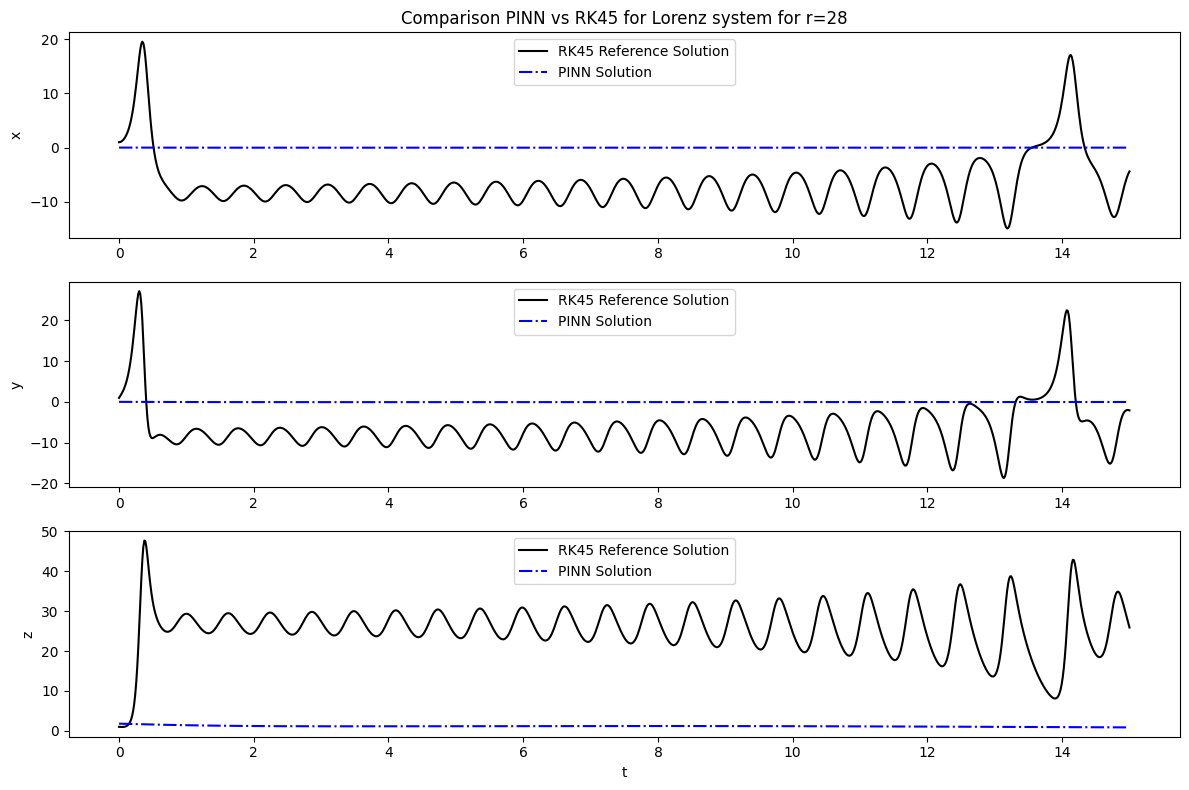

In [11]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

### Baseline result for parameter optimization (10,-5,20)

Training started...
Epoch     0 | Loss: 1.3549e+02 | Data/IC-Loss: 2.5736e+02 | Physics-Loss: 1.3623e+01
Epoch  1000 | Loss: 1.2129e+02 | Data/IC-Loss: 2.3559e+02 | Physics-Loss: 6.9978e+00
Epoch  2000 | Loss: 1.2125e+02 | Data/IC-Loss: 2.3515e+02 | Physics-Loss: 7.3384e+00
Epoch  3000 | Loss: 1.2125e+02 | Data/IC-Loss: 2.3522e+02 | Physics-Loss: 7.2910e+00
Epoch  4000 | Loss: 1.2127e+02 | Data/IC-Loss: 2.3524e+02 | Physics-Loss: 7.2930e+00
Epoch  5000 | Loss: 1.2125e+02 | Data/IC-Loss: 2.3524e+02 | Physics-Loss: 7.2497e+00
Epoch  6000 | Loss: 1.2126e+02 | Data/IC-Loss: 2.3524e+02 | Physics-Loss: 7.2736e+00
Epoch  7000 | Loss: 1.2128e+02 | Data/IC-Loss: 2.3524e+02 | Physics-Loss: 7.3262e+00
Epoch  8000 | Loss: 1.2125e+02 | Data/IC-Loss: 2.3524e+02 | Physics-Loss: 7.2666e+00
Epoch  9000 | Loss: 1.2128e+02 | Data/IC-Loss: 2.3524e+02 | Physics-Loss: 7.3221e+00
Epoch 10000 | Loss: 1.2127e+02 | Data/IC-Loss: 2.3524e+02 | Physics-Loss: 7.2903e+00
Epoch 11000 | Loss: 1.2128e+02 | Data/IC-Loss

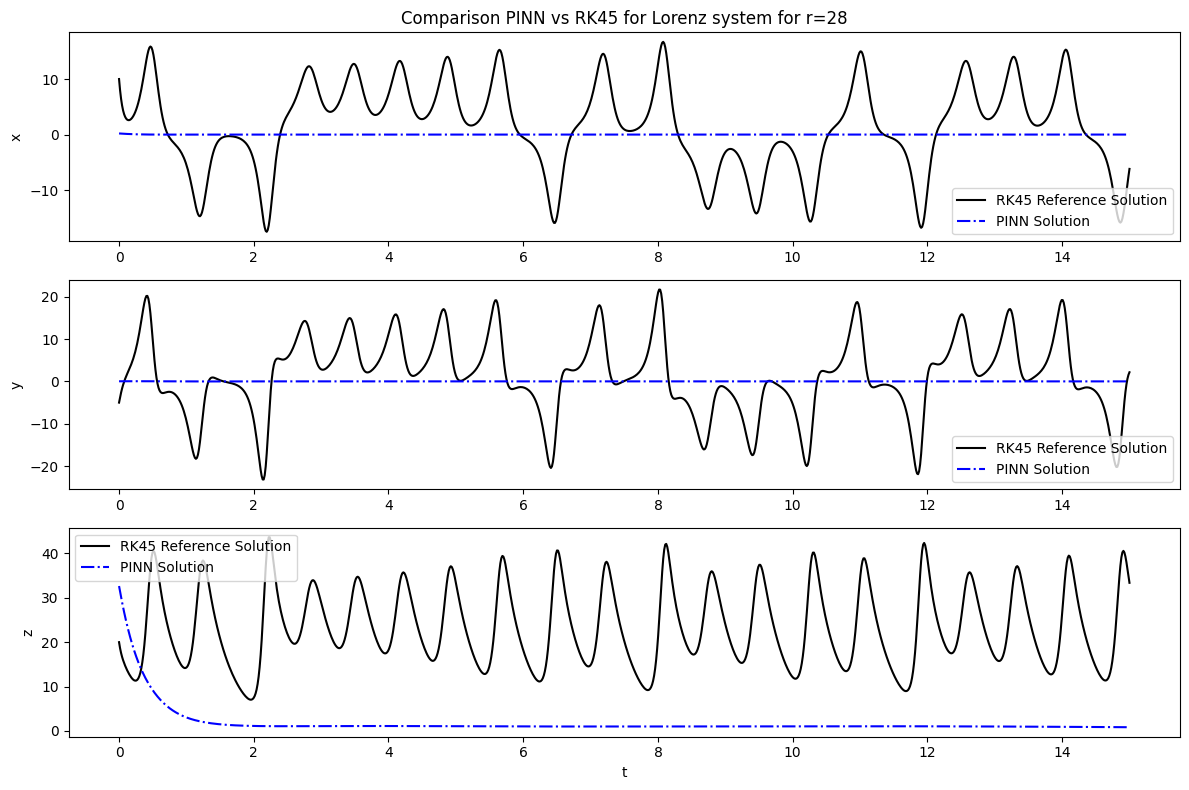

In [24]:
# ──────────────── Global configuration ────────────────
# Lorenz system parameter
A = 10
B = 28
C = 8/3

INITIAL_CONDITIONS = np.array([10.0, -5.0, 20.0], dtype=np.float32)

# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.09
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 20000 
COLLOCATION_POINTS = 1024
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

# Create RK-45 reference solution
t_eval, sol_rk45 = hf.ref_solution(A, B, C, t_min, t_max, INITIAL_CONDITIONS)

# Create RK-45 reference solution
base_IC = np.array([10.0, -5.0, 20.0], dtype=np.float32)
B_0 = 28
t_eval, sol_rk45_base_IC_r0 = hf.ref_solution(A, B_0, C, t_min, t_max, base_IC)

# Create PINN model without normalization
model_base_IC_r0 = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
t_data, y_data = hf.generate_noisy_data(sol_rk45_base_IC_r0, t_min, t_max)

pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=False
    )

y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)

title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

## Test 1: collocation points = 5000

In [12]:
# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.09
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 15000 
COLLOCATION_POINTS = 5000
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

In [13]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=False
    )


Training started...
Epoch     0 | Loss: 1.3488e+02 | Data/IC-Loss: 2.6035e+02 | Physics-Loss: 9.4095e+00
Epoch  1000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5824e+02 | Physics-Loss: 8.9617e+00
Epoch  2000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5818e+02 | Physics-Loss: 9.0258e+00
Epoch  3000 | Loss: 1.3362e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 9.0228e+00
Epoch  4000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 8.9948e+00
Epoch  5000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 8.9903e+00
Epoch  6000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 9.0176e+00
Epoch  7000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 8.9981e+00
Epoch  8000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 8.9884e+00
Epoch  9000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 9.0180e+00
Epoch 10000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 8.9877e+00
Epoch 11000 | Loss: 1.3359e+02 | Data/IC-Loss

In [14]:
y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)

## Results of Test 1 (5000 collocation points)

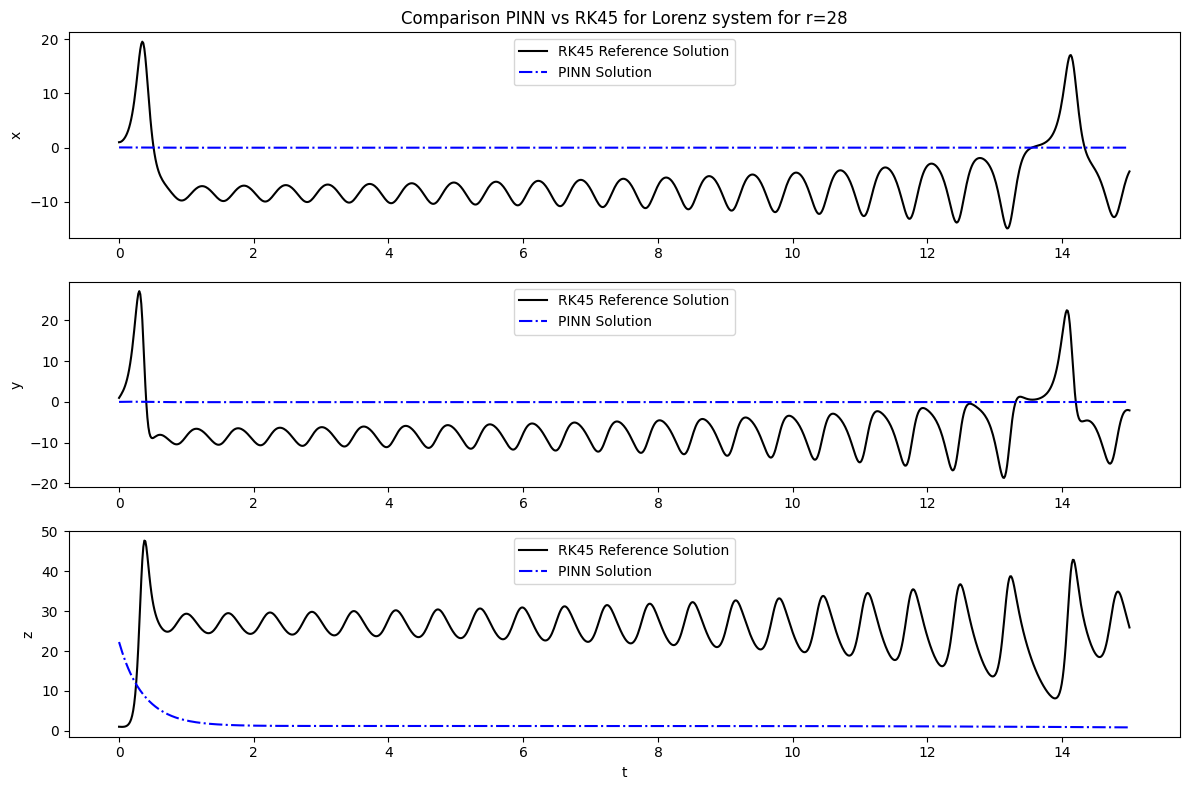

In [15]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

increasing the collocation points has resultet in an increased accuracy.

## Test 2: collocation points = 6000

In [16]:
# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.09
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 15000 
COLLOCATION_POINTS = 6000
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

In [17]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=False
    )

Training started...
Epoch     0 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 8.9866e+00
Epoch  1000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0071e+00
Epoch  2000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 8.9891e+00
Epoch  3000 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 8.9828e+00
Epoch  4000 | Loss: 1.3362e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 9.0194e+00
Epoch  5000 | Loss: 1.3362e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 9.0369e+00
Epoch  6000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 9.0083e+00
Epoch  7000 | Loss: 1.3363e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 9.0520e+00
Epoch  8000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 9.0165e+00
Epoch  9000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 9.0226e+00
Epoch 10000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 9.0138e+00
Epoch 11000 | Loss: 1.3361e+02 | Data/IC-Loss

In [18]:
y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)

## Results of Test 2 (6000 collocation points)

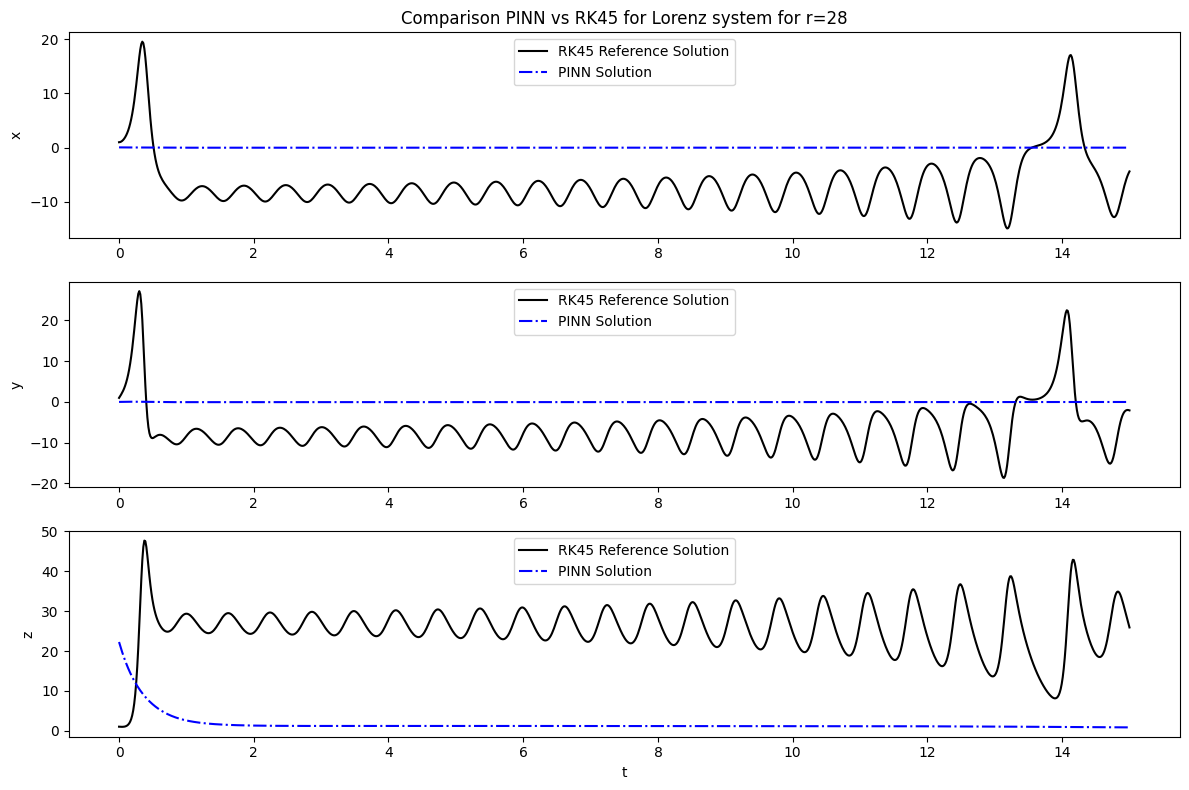

In [19]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

No change in the output of the training

## Test 3: collocation points = 4000

In [20]:
# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.09
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 15000 
COLLOCATION_POINTS = 4000
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

In [21]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=False
    )

Training started...
Epoch     0 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 8.9895e+00
Epoch  1000 | Loss: 1.3363e+02 | Data/IC-Loss: 2.5822e+02 | Physics-Loss: 9.0312e+00
Epoch  2000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5819e+02 | Physics-Loss: 9.0435e+00
Epoch  3000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0053e+00
Epoch  4000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0182e+00
Epoch  5000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9975e+00
Epoch  6000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0191e+00
Epoch  7000 | Loss: 1.3363e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0502e+00
Epoch  8000 | Loss: 1.3358e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9533e+00
Epoch  9000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0250e+00
Epoch 10000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0059e+00
Epoch 11000 | Loss: 1.3361e+02 | Data/IC-Loss

In [22]:
y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)

## Results of Test 3 (collocation points 4000)

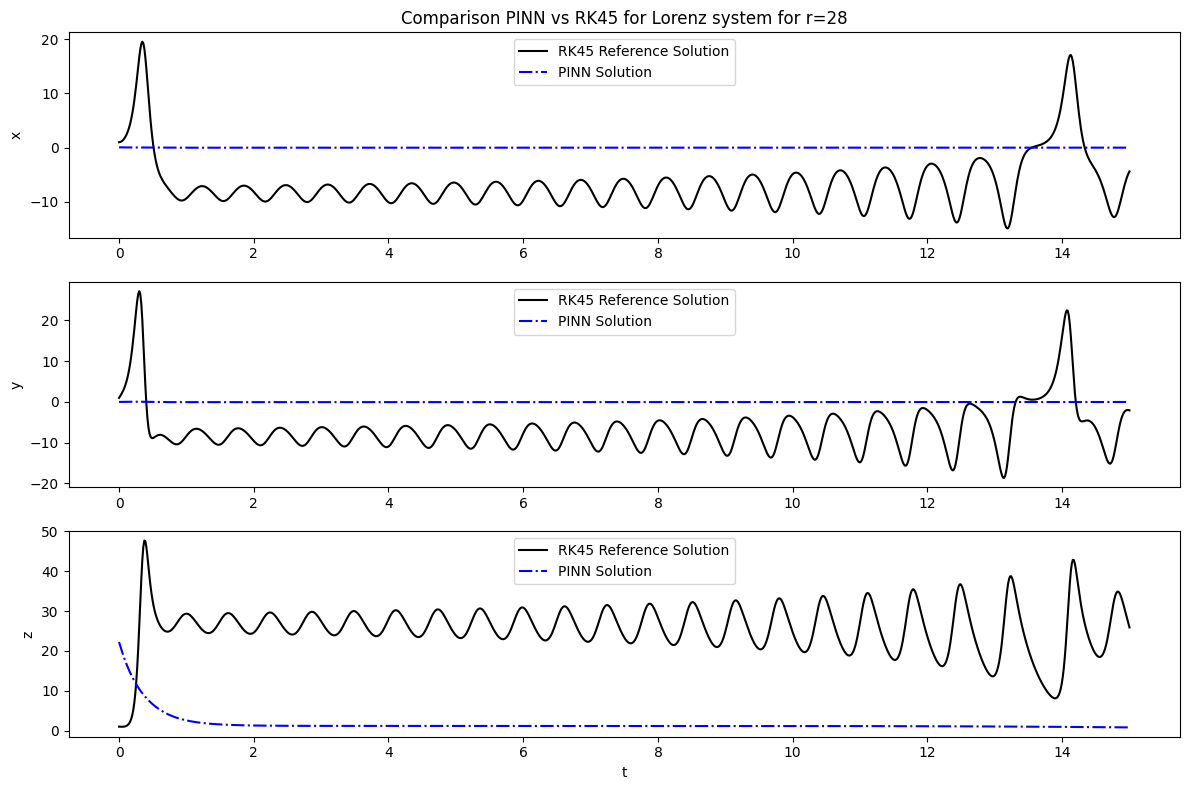

In [23]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

Still no change in the training result

## Test 4: collocation points = 2000

In [24]:
# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.09
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 15000 
COLLOCATION_POINTS = 2000
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

In [25]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=False
    )

Training started...
Epoch     0 | Loss: 1.3358e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9509e+00
Epoch  1000 | Loss: 1.3358e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 8.9604e+00
Epoch  2000 | Loss: 1.3362e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0734e+00
Epoch  3000 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 8.9706e+00
Epoch  4000 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9690e+00
Epoch  5000 | Loss: 1.3365e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.1045e+00
Epoch  6000 | Loss: 1.3362e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0398e+00
Epoch  7000 | Loss: 1.3362e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0347e+00
Epoch  8000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0228e+00
Epoch  9000 | Loss: 1.3363e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0674e+00
Epoch 10000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0196e+00
Epoch 11000 | Loss: 1.3362e+02 | Data/IC-Loss

In [26]:
y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)

## Results of Test 4 (collocation points 2000)

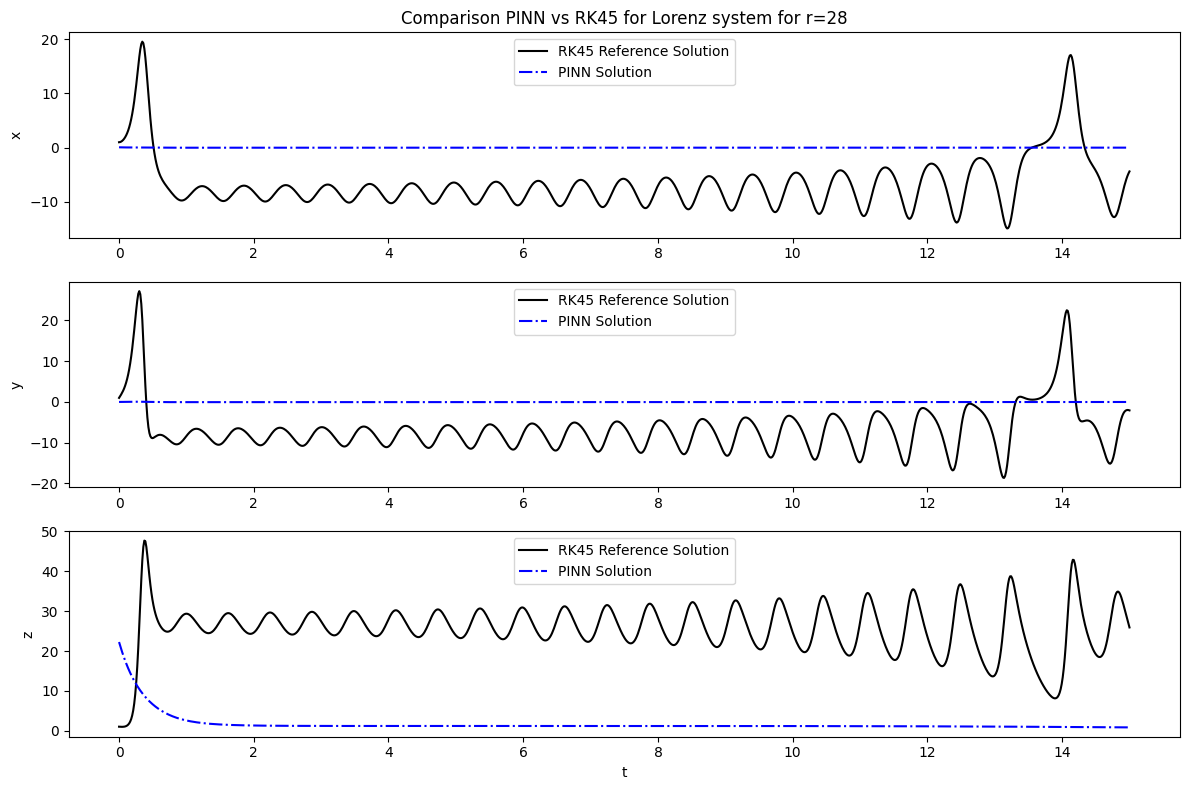

In [27]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

change of the collocation didn't affect training. Further training will be executed with 4000 

## Test 5: learning rate = 0.011

In [28]:
# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.011
DECAY_RATE = 0.09
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 15000 
COLLOCATION_POINTS = 4000
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

In [29]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=False
    )

Training started...
Epoch     0 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0097e+00
Epoch  1000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 9.0190e+00
Epoch  2000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5827e+02 | Physics-Loss: 8.9607e+00
Epoch  3000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0046e+00
Epoch  4000 | Loss: 1.3362e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0369e+00
Epoch  5000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0157e+00
Epoch  6000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9934e+00
Epoch  7000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9940e+00
Epoch  8000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9941e+00
Epoch  9000 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9797e+00
Epoch 10000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0087e+00
Epoch 11000 | Loss: 1.3358e+02 | Data/IC-Loss

In [30]:
y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)

## Results of Test 5 (learning rate 0,011)

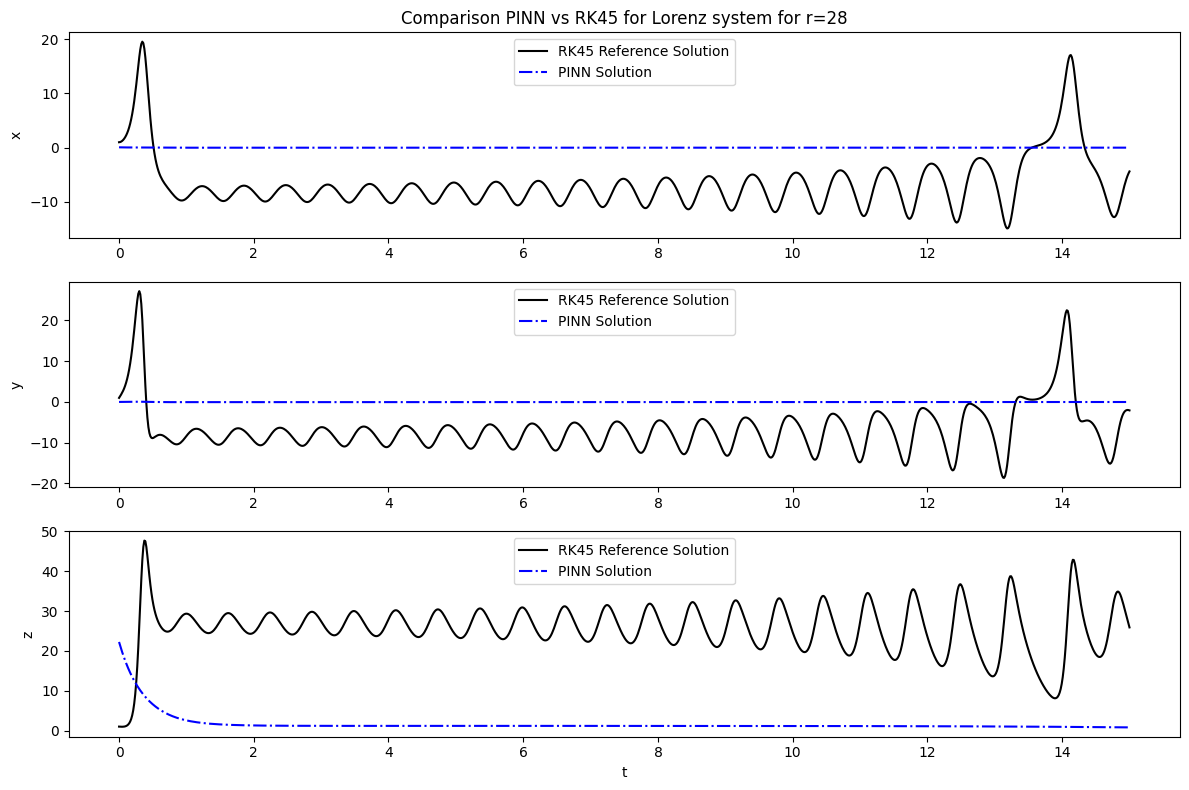

In [31]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

Training result didn't change

## Test 6: learning rate = 0.0105

In [32]:
# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.0105
DECAY_RATE = 0.09
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 15000 
COLLOCATION_POINTS = 1024
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

In [33]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=False
    )

Training started...
Epoch     0 | Loss: 1.3362e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0435e+00
Epoch  1000 | Loss: 1.3362e+02 | Data/IC-Loss: 2.5790e+02 | Physics-Loss: 9.3471e+00
Epoch  2000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0552e+00
Epoch  3000 | Loss: 1.3365e+02 | Data/IC-Loss: 2.5819e+02 | Physics-Loss: 9.0998e+00
Epoch  4000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0045e+00
Epoch  5000 | Loss: 1.3358e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9586e+00
Epoch  6000 | Loss: 1.3357e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9397e+00
Epoch  7000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9993e+00
Epoch  8000 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9824e+00
Epoch  9000 | Loss: 1.3363e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0626e+00
Epoch 10000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0303e+00
Epoch 11000 | Loss: 1.3361e+02 | Data/IC-Loss

In [34]:
y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)

## Results of Test 6 (learning rate 0,0105)

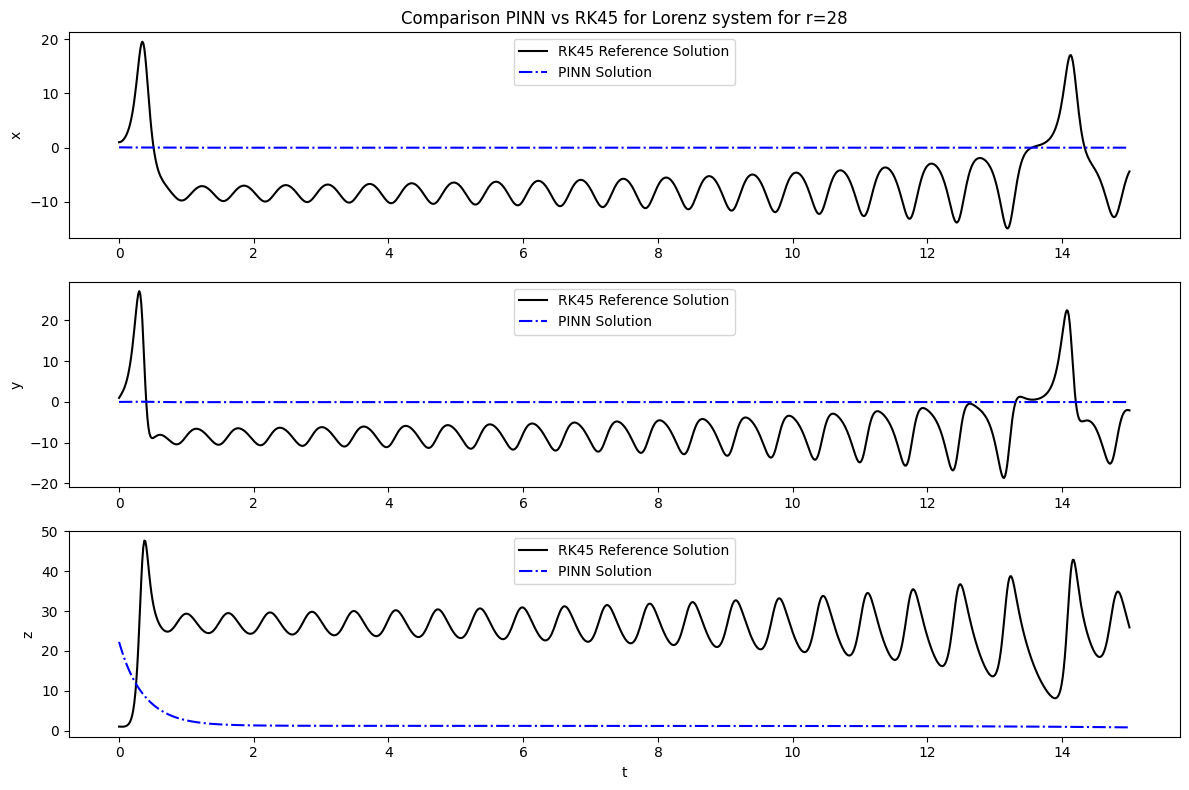

In [35]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

Training result didn't change

## Test 7: learning rate = 0.0095

Output decreased in accuracy, further testing required.

In [36]:
# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.0095
DECAY_RATE = 0.09
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 15000 
COLLOCATION_POINTS = 1024
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

In [37]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=False
    )

Training started...
Epoch     0 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0181e+00
Epoch  1000 | Loss: 1.3362e+02 | Data/IC-Loss: 2.5830e+02 | Physics-Loss: 8.9269e+00
Epoch  2000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0602e+00
Epoch  3000 | Loss: 1.3356e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 8.9521e+00
Epoch  4000 | Loss: 1.3356e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 8.9545e+00
Epoch  5000 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0186e+00
Epoch  6000 | Loss: 1.3363e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0853e+00
Epoch  7000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0300e+00
Epoch  8000 | Loss: 1.3358e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 8.9927e+00
Epoch  9000 | Loss: 1.3363e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0873e+00
Epoch 10000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0422e+00
Epoch 11000 | Loss: 1.3364e+02 | Data/IC-Loss

In [38]:
y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)

## Results of Test 7 (learning rate 0,0095)

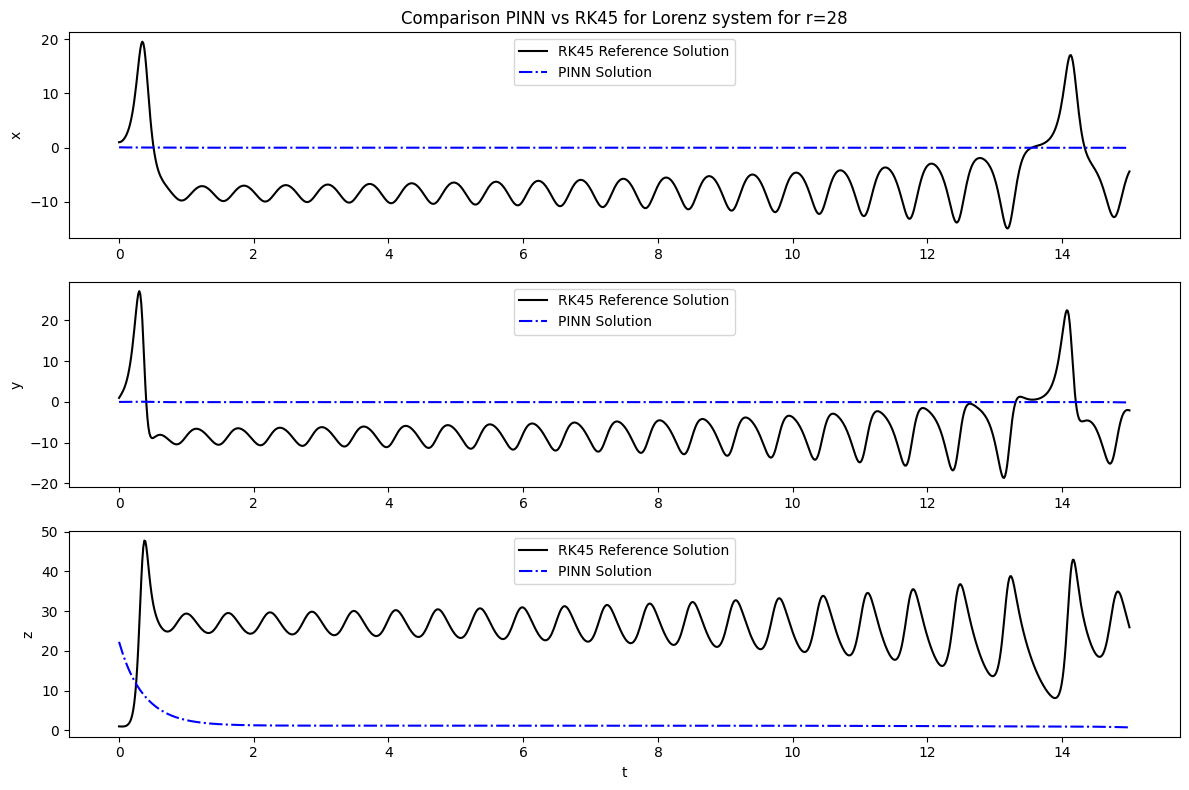

In [39]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

Training result changed slightly

## Test 8: decay rate = 0.095

In [40]:
# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.095
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 15000 
COLLOCATION_POINTS = 4000
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

In [41]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=False
    )

Training started...
Epoch     0 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0105e+00
Epoch  1000 | Loss: 1.3362e+02 | Data/IC-Loss: 2.5810e+02 | Physics-Loss: 9.1291e+00
Epoch  2000 | Loss: 1.3358e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 8.9977e+00
Epoch  3000 | Loss: 1.3362e+02 | Data/IC-Loss: 2.5819e+02 | Physics-Loss: 9.0376e+00
Epoch  4000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9961e+00
Epoch  5000 | Loss: 1.3362e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0255e+00
Epoch  6000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9968e+00
Epoch  7000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9999e+00
Epoch  8000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9986e+00
Epoch  9000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0117e+00
Epoch 10000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9886e+00
Epoch 11000 | Loss: 1.3360e+02 | Data/IC-Loss

In [42]:
y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)

## Results of Test 8 (decay rate 0,095)

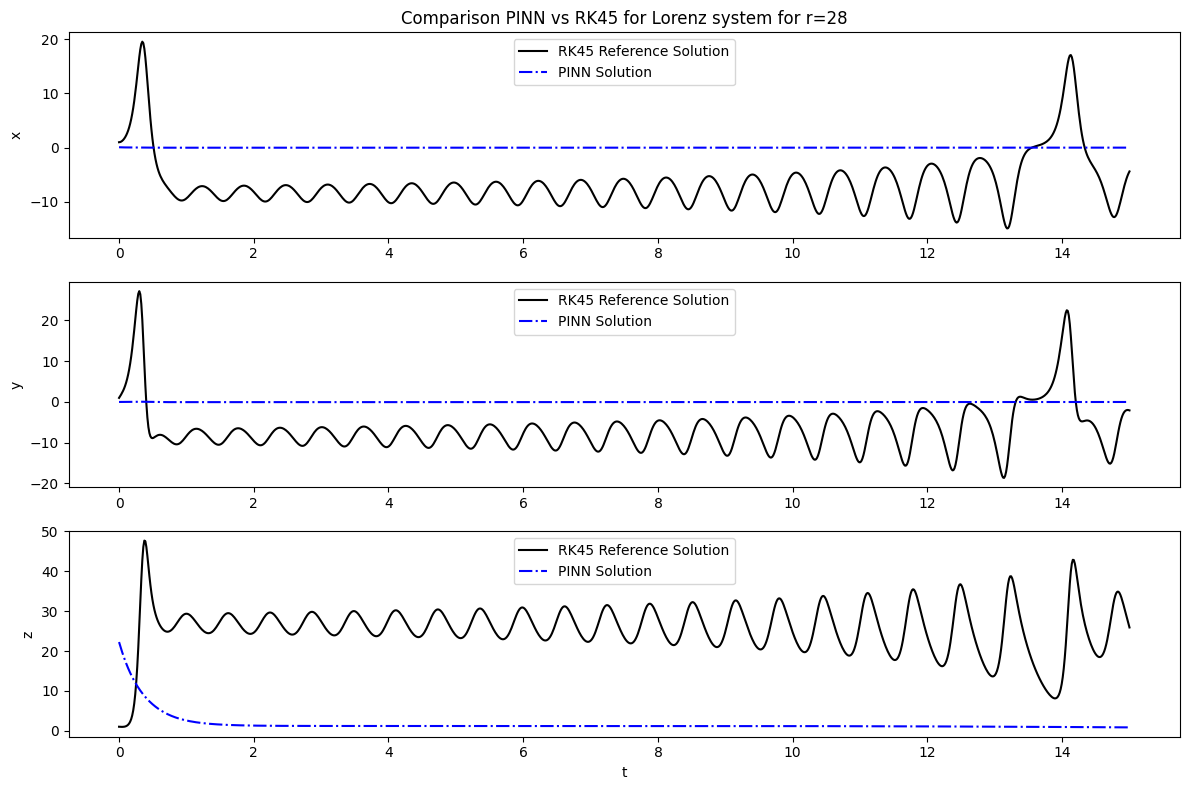

In [43]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

Slight reduction of accuracy

## Test 9: decay rate = 0.09

In [44]:
# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.09
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 15000 
COLLOCATION_POINTS = 4000
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

In [45]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=False
    )

Training started...
Epoch     0 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9878e+00
Epoch  1000 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5809e+02 | Physics-Loss: 9.0873e+00
Epoch  2000 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5818e+02 | Physics-Loss: 9.0018e+00
Epoch  3000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0498e+00
Epoch  4000 | Loss: 1.3362e+02 | Data/IC-Loss: 2.5816e+02 | Physics-Loss: 9.0827e+00
Epoch  5000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0485e+00
Epoch  6000 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0184e+00
Epoch  7000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0525e+00
Epoch  8000 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0073e+00
Epoch  9000 | Loss: 1.3357e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 8.9799e+00
Epoch 10000 | Loss: 1.3362e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0768e+00
Epoch 11000 | Loss: 1.3358e+02 | Data/IC-Loss

In [46]:
y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)

## Results of Test 9 (decay rate 0,09)

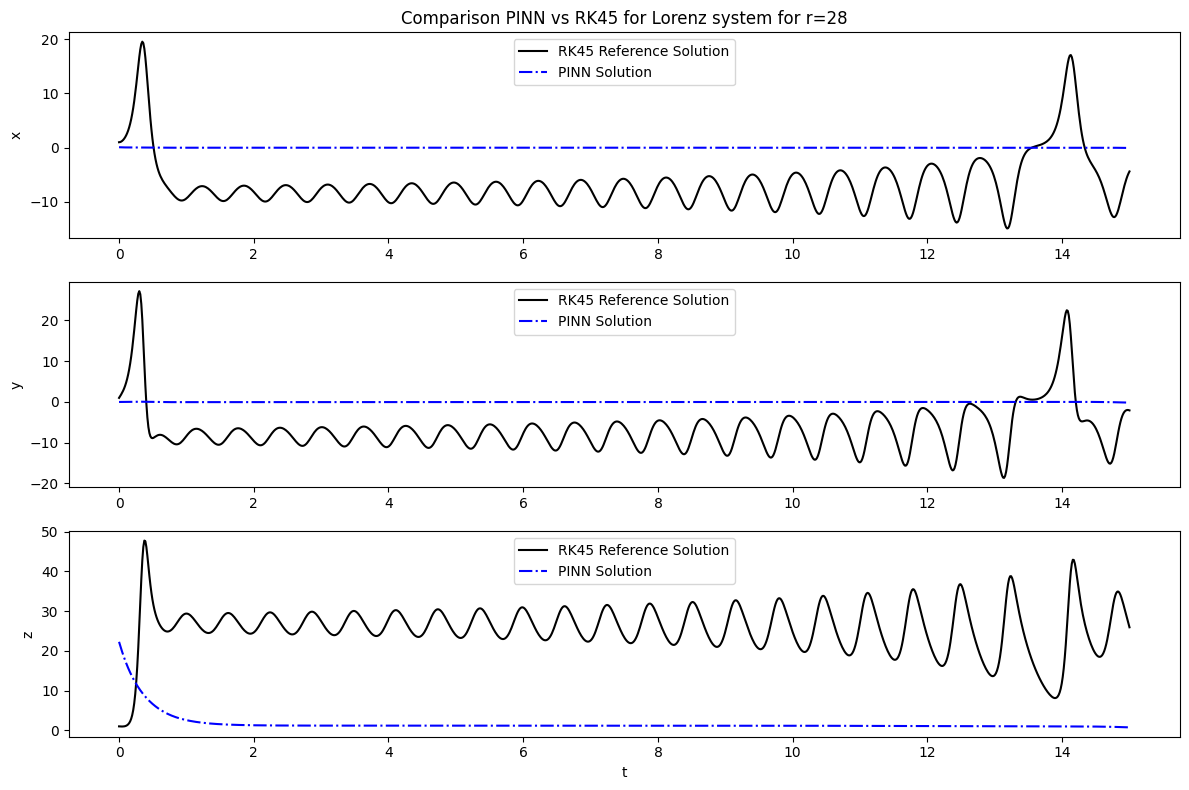

In [47]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

Slight increase in accuracy

## Test 10: decay rate = 0.095

In [48]:
# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.095
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 15000 
COLLOCATION_POINTS = 4000
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

In [49]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=False
    )

Training started...
Epoch     0 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0448e+00
Epoch  1000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5819e+02 | Physics-Loss: 9.0362e+00
Epoch  2000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 8.9903e+00
Epoch  3000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9989e+00
Epoch  4000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0161e+00
Epoch  5000 | Loss: 1.3362e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0365e+00
Epoch  6000 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9684e+00
Epoch  7000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0096e+00
Epoch  8000 | Loss: 1.3362e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0282e+00
Epoch  9000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9993e+00
Epoch 10000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9856e+00
Epoch 11000 | Loss: 1.3363e+02 | Data/IC-Loss

In [50]:
y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)

## Results of Test 10 (decay rate 0,095)

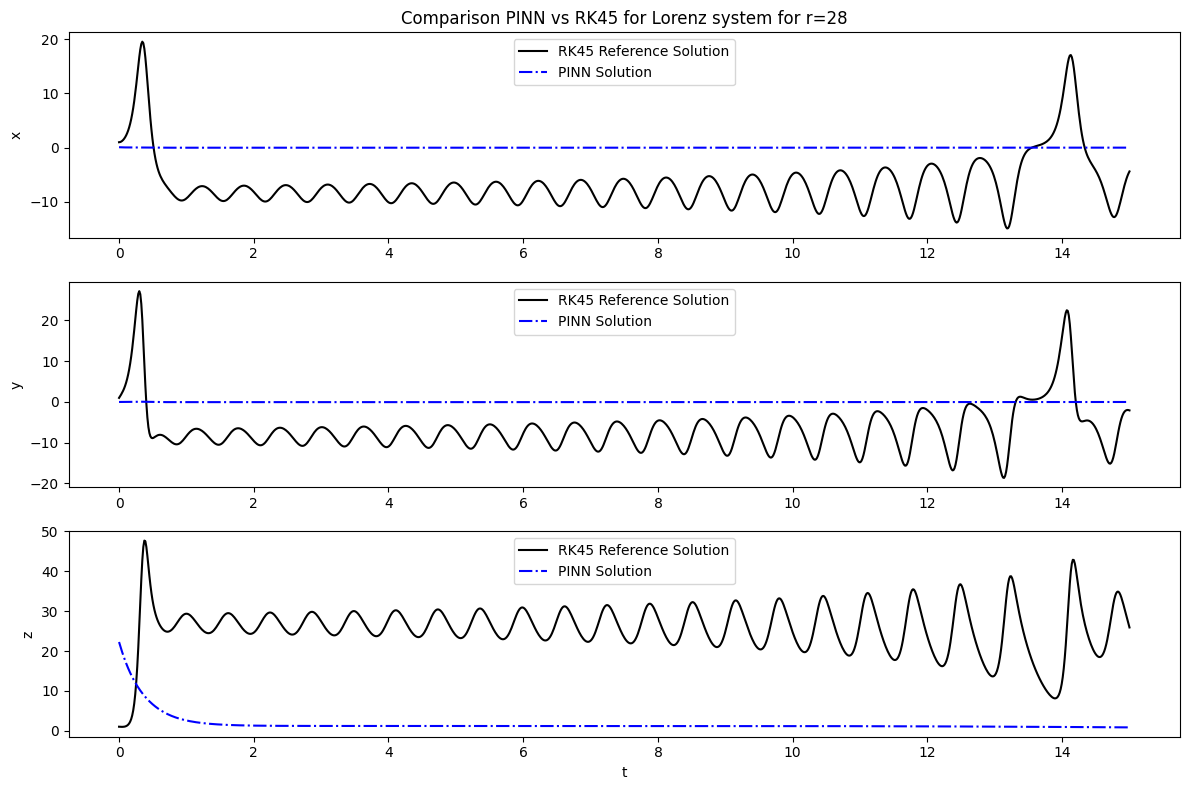

In [51]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

Minimal decrease of accuracy

## Test 11: decay rate = 0.08

In [52]:
# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.08
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 15000 
COLLOCATION_POINTS = 4000
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

In [53]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=False
    )

Training started...
Epoch     0 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0226e+00
Epoch  1000 | Loss: 1.3364e+02 | Data/IC-Loss: 2.5823e+02 | Physics-Loss: 9.0557e+00
Epoch  2000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 9.0176e+00
Epoch  3000 | Loss: 1.3362e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0473e+00
Epoch  4000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0042e+00
Epoch  5000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0061e+00
Epoch  6000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0017e+00
Epoch  7000 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9781e+00
Epoch  8000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9929e+00
Epoch  9000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 9.0004e+00
Epoch 10000 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9734e+00
Epoch 11000 | Loss: 1.3359e+02 | Data/IC-Loss

In [54]:
y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)

## Results of Test 11 (decay rate 0,08)

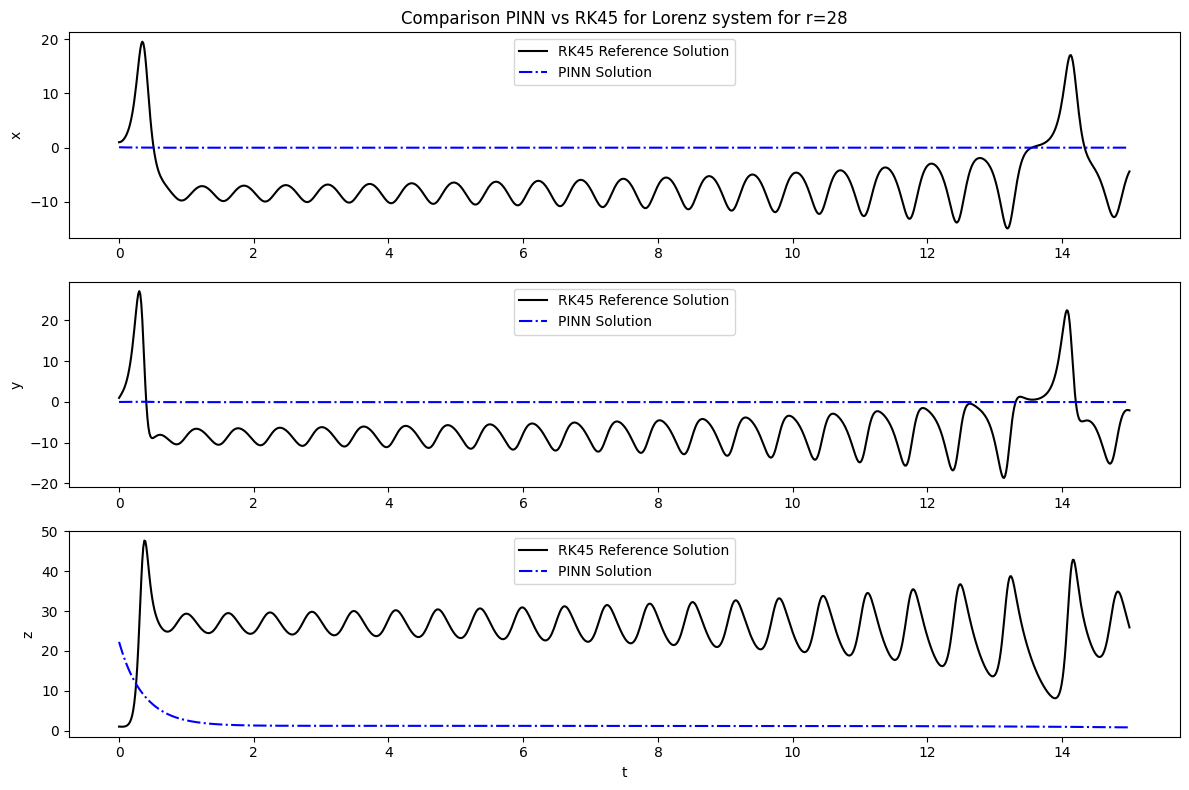

In [55]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

Training result has not changed from previous

In [56]:
DECAY_RATE = 0.95

## Test 12: alpha data = 0.45

In [57]:
# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.095
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 15000 
COLLOCATION_POINTS = 4000
ALPHA_DATA = 0.45

# Domain
t_min, t_max = 0.0, 15.0

In [58]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=False
    )

Training started...
Epoch     0 | Loss: 1.2112e+02 | Data/IC-Loss: 2.5820e+02 | Physics-Loss: 8.9693e+00
Epoch  1000 | Loss: 1.2100e+02 | Data/IC-Loss: 2.6138e+02 | Physics-Loss: 6.1367e+00
Epoch  2000 | Loss: 1.2098e+02 | Data/IC-Loss: 2.6136e+02 | Physics-Loss: 6.1233e+00
Epoch  3000 | Loss: 1.2100e+02 | Data/IC-Loss: 2.6137e+02 | Physics-Loss: 6.1591e+00
Epoch  4000 | Loss: 1.2099e+02 | Data/IC-Loss: 2.6139e+02 | Physics-Loss: 6.1187e+00
Epoch  5000 | Loss: 1.2099e+02 | Data/IC-Loss: 2.6138e+02 | Physics-Loss: 6.1281e+00
Epoch  6000 | Loss: 1.2099e+02 | Data/IC-Loss: 2.6138e+02 | Physics-Loss: 6.1242e+00
Epoch  7000 | Loss: 1.2100e+02 | Data/IC-Loss: 2.6138e+02 | Physics-Loss: 6.1442e+00
Epoch  8000 | Loss: 1.2098e+02 | Data/IC-Loss: 2.6138e+02 | Physics-Loss: 6.1069e+00
Epoch  9000 | Loss: 1.2097e+02 | Data/IC-Loss: 2.6138e+02 | Physics-Loss: 6.0861e+00
Epoch 10000 | Loss: 1.2098e+02 | Data/IC-Loss: 2.6138e+02 | Physics-Loss: 6.1074e+00
Epoch 11000 | Loss: 1.2100e+02 | Data/IC-Loss

In [59]:
y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)

## Results of Test 12 (alpha = 0,45)

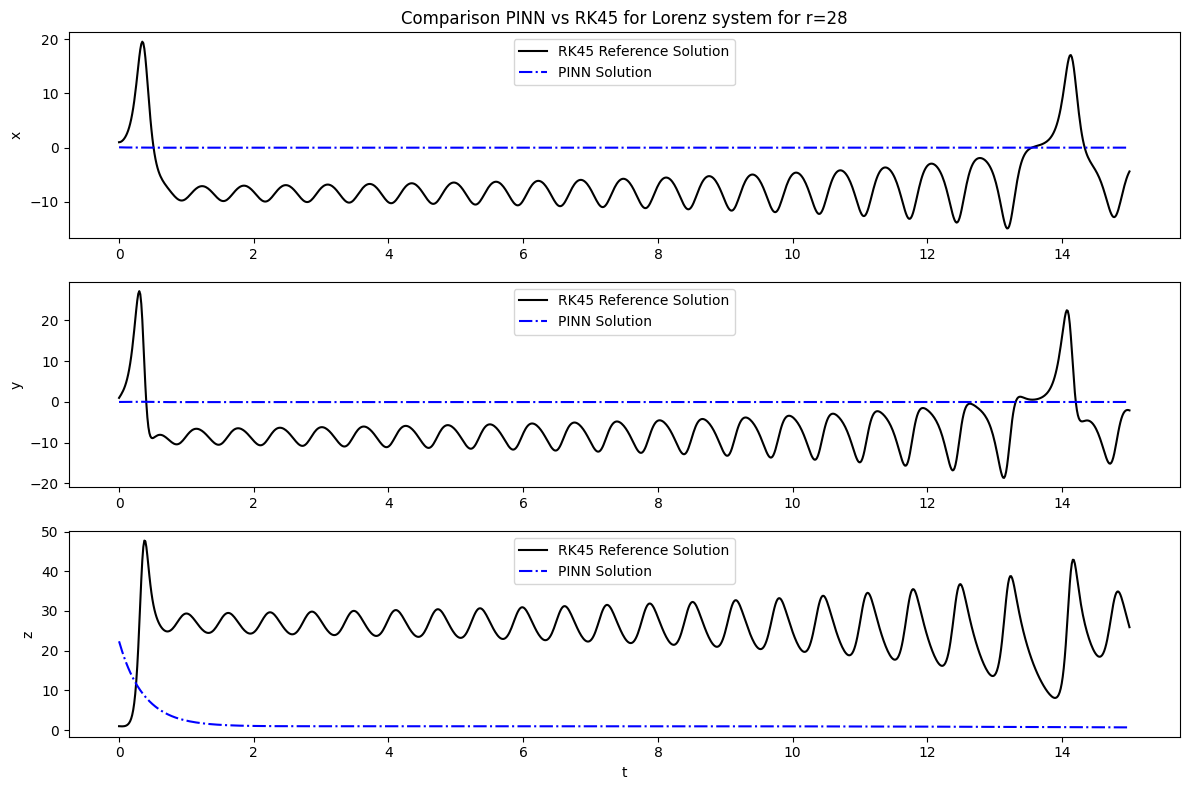

In [60]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

Slight decrease of accuracy

## Test 13: alpha data = 0.55

In [61]:
# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.095
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 15000 
COLLOCATION_POINTS = 4000
ALPHA_DATA = 0.55

# Domain
t_min, t_max = 0.0, 15.0

In [62]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=False
    )

Training started...
Epoch     0 | Loss: 1.4652e+02 | Data/IC-Loss: 2.6138e+02 | Physics-Loss: 6.1270e+00
Epoch  1000 | Loss: 1.4589e+02 | Data/IC-Loss: 2.5486e+02 | Physics-Loss: 1.2712e+01
Epoch  2000 | Loss: 1.4588e+02 | Data/IC-Loss: 2.5444e+02 | Physics-Loss: 1.3185e+01
Epoch  3000 | Loss: 1.4586e+02 | Data/IC-Loss: 2.5442e+02 | Physics-Loss: 1.3191e+01
Epoch  4000 | Loss: 1.4589e+02 | Data/IC-Loss: 2.5441e+02 | Physics-Loss: 1.3254e+01
Epoch  5000 | Loss: 1.4587e+02 | Data/IC-Loss: 2.5441e+02 | Physics-Loss: 1.3208e+01
Epoch  6000 | Loss: 1.4588e+02 | Data/IC-Loss: 2.5441e+02 | Physics-Loss: 1.3229e+01
Epoch  7000 | Loss: 1.4590e+02 | Data/IC-Loss: 2.5441e+02 | Physics-Loss: 1.3275e+01
Epoch  8000 | Loss: 1.4587e+02 | Data/IC-Loss: 2.5441e+02 | Physics-Loss: 1.3218e+01
Epoch  9000 | Loss: 1.4585e+02 | Data/IC-Loss: 2.5441e+02 | Physics-Loss: 1.3162e+01
Epoch 10000 | Loss: 1.4589e+02 | Data/IC-Loss: 2.5441e+02 | Physics-Loss: 1.3244e+01
Epoch 11000 | Loss: 1.4589e+02 | Data/IC-Loss

In [63]:
y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)

## Results of Test 13 (alpha = 0,55)

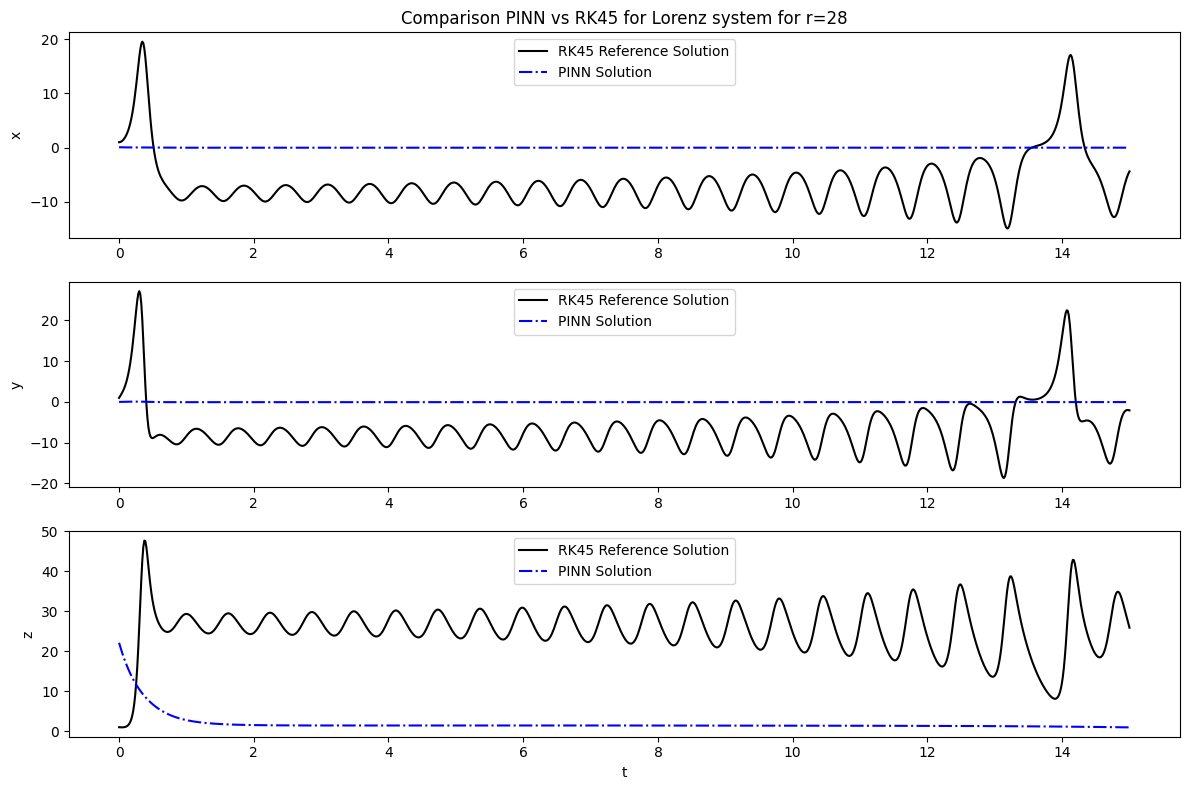

In [64]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

Accuracy has decreased from previous test

In [65]:
ALPHA_DATA = 0.5

## Test 14: neurons per layer = 50

In [66]:
# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 50
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.095
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 15000 
COLLOCATION_POINTS = 4000
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

In [67]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=False
    )

Training started...
Epoch     0 | Loss: 1.3381e+02 | Data/IC-Loss: 2.5441e+02 | Physics-Loss: 1.3213e+01
Epoch  1000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5826e+02 | Physics-Loss: 8.9524e+00
Epoch  2000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5811e+02 | Physics-Loss: 9.0995e+00
Epoch  3000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0538e+00
Epoch  4000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5816e+02 | Physics-Loss: 9.0507e+00
Epoch  5000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5816e+02 | Physics-Loss: 9.0618e+00
Epoch  6000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5816e+02 | Physics-Loss: 9.0425e+00
Epoch  7000 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5816e+02 | Physics-Loss: 9.0221e+00
Epoch  8000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5816e+02 | Physics-Loss: 9.0348e+00
Epoch  9000 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5816e+02 | Physics-Loss: 9.0184e+00
Epoch 10000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5816e+02 | Physics-Loss: 9.0554e+00
Epoch 11000 | Loss: 1.3358e+02 | Data/IC-Loss

In [68]:
y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)

## Results of Test 14 (50 neurons per layer)

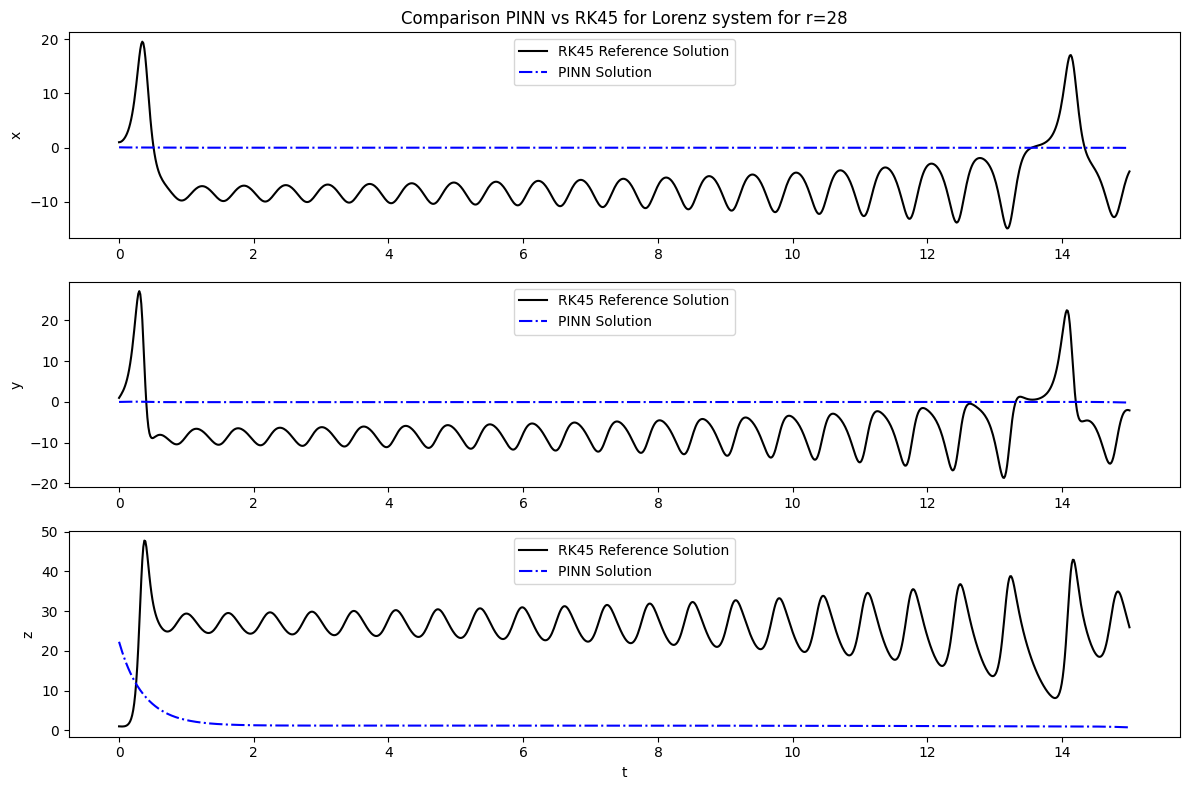

In [69]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

Increase of training accuracy

## Test 15: 10 hidden layers with 50 neurons per layer

In [70]:
# PINN architecture
HIDDEN_LAYER = 10
NEURONS_PER_LAYER = 50
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.095
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 15000 
COLLOCATION_POINTS = 4000
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

In [71]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=False
    )

Training started...
Epoch     0 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5816e+02 | Physics-Loss: 9.0204e+00
Epoch  1000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5826e+02 | Physics-Loss: 8.9309e+00
Epoch  2000 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 8.9712e+00
Epoch  3000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5822e+02 | Physics-Loss: 9.0044e+00
Epoch  4000 | Loss: 1.3362e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 9.0397e+00
Epoch  5000 | Loss: 1.3364e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 9.0743e+00
Epoch  6000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 9.0230e+00
Epoch  7000 | Loss: 1.3363e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 9.0483e+00
Epoch  8000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 9.0153e+00
Epoch  9000 | Loss: 1.3363e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 9.0555e+00
Epoch 10000 | Loss: 1.3363e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 9.0551e+00
Epoch 11000 | Loss: 1.3362e+02 | Data/IC-Loss

In [72]:
y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)

## Results of Test 15 (10 hidden layers and 50 neurons per layer)

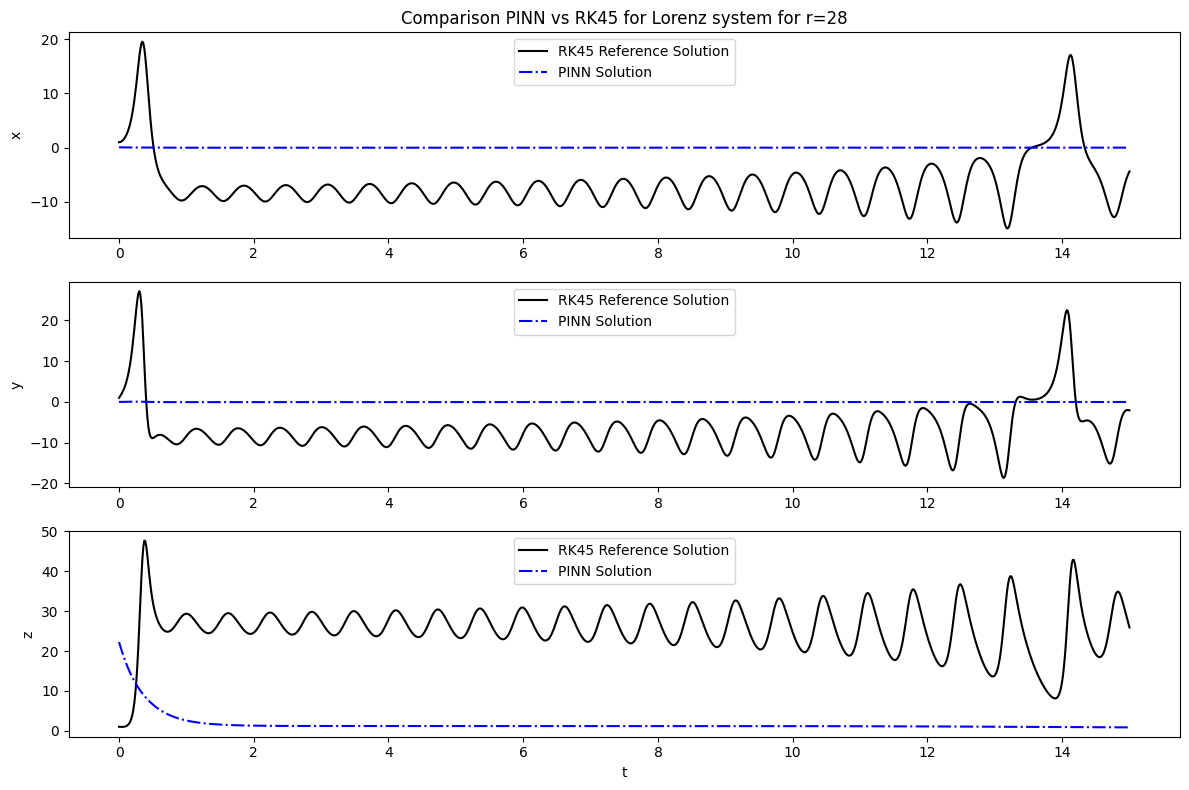

In [73]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

Training result still has no accuracy

## Test 16: 10 hidden layers with 30 neurons per layer

In [74]:
# PINN architecture
HIDDEN_LAYER = 10
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.095
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 15000 
COLLOCATION_POINTS = 4000
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

In [75]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=False
    )

Training started...
Epoch     0 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5821e+02 | Physics-Loss: 8.9777e+00
Epoch  1000 | Loss: 1.3362e+02 | Data/IC-Loss: 2.5823e+02 | Physics-Loss: 8.9989e+00
Epoch  2000 | Loss: 1.3356e+02 | Data/IC-Loss: 2.5816e+02 | Physics-Loss: 8.9655e+00
Epoch  3000 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5816e+02 | Physics-Loss: 9.0158e+00
Epoch  4000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0512e+00
Epoch  5000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0422e+00
Epoch  6000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0281e+00
Epoch  7000 | Loss: 1.3362e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0725e+00
Epoch  8000 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0145e+00
Epoch  9000 | Loss: 1.3361e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0587e+00
Epoch 10000 | Loss: 1.3357e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 8.9809e+00
Epoch 11000 | Loss: 1.3361e+02 | Data/IC-Loss

In [76]:
y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)

## Results of Test 16 (10 hidden layers with 30 neurons per layer)

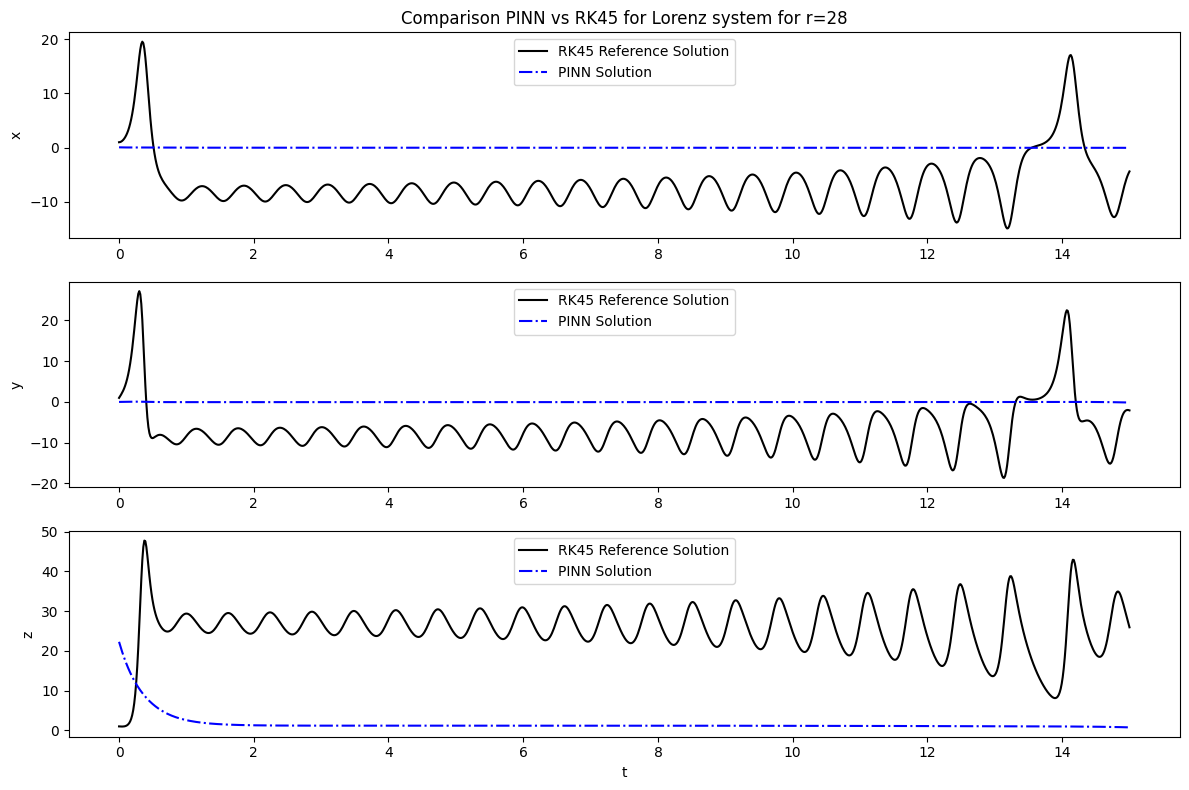

In [77]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

Training result still has no accuracy

## currently best settings: 
HIDDEN_LAYER = 6 <br>
NEURONS_PER_LAYER = 30 <br>
DECAY_RATE = 0.8 <br>
OPTIMIZER = tf.keras.optimizers.Adam <br>
EPOCHS = 20000 <br>
COLLOCATION_POINTS = 4000<br>
ALPHA_DATA = 0.5 <br>
NORMALIZE_INPUT = False <br>
DATA_ACTIVE = True <br>
CHAOTIC = False

## Test 17: current best settings with 20000 epochs

In [78]:
# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.08
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 20000 
COLLOCATION_POINTS = 4000
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

In [79]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=False
    )

Training started...
Epoch     0 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5817e+02 | Physics-Loss: 9.0219e+00
Epoch  1000 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5810e+02 | Physics-Loss: 9.0749e+00
Epoch  2000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5807e+02 | Physics-Loss: 9.1260e+00
Epoch  3000 | Loss: 1.3360e+02 | Data/IC-Loss: 2.5813e+02 | Physics-Loss: 9.0648e+00
Epoch  4000 | Loss: 1.3358e+02 | Data/IC-Loss: 2.5814e+02 | Physics-Loss: 9.0243e+00
Epoch  5000 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5814e+02 | Physics-Loss: 9.0375e+00
Epoch  6000 | Loss: 1.3358e+02 | Data/IC-Loss: 2.5814e+02 | Physics-Loss: 9.0289e+00
Epoch  7000 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5814e+02 | Physics-Loss: 9.0373e+00
Epoch  8000 | Loss: 1.3359e+02 | Data/IC-Loss: 2.5814e+02 | Physics-Loss: 9.0384e+00
Epoch  9000 | Loss: 1.3356e+02 | Data/IC-Loss: 2.5814e+02 | Physics-Loss: 8.9874e+00
Epoch 10000 | Loss: 1.3356e+02 | Data/IC-Loss: 2.5814e+02 | Physics-Loss: 8.9826e+00
Epoch 11000 | Loss: 1.3360e+02 | Data/IC-Loss

In [80]:
y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)

## Results of Test 17

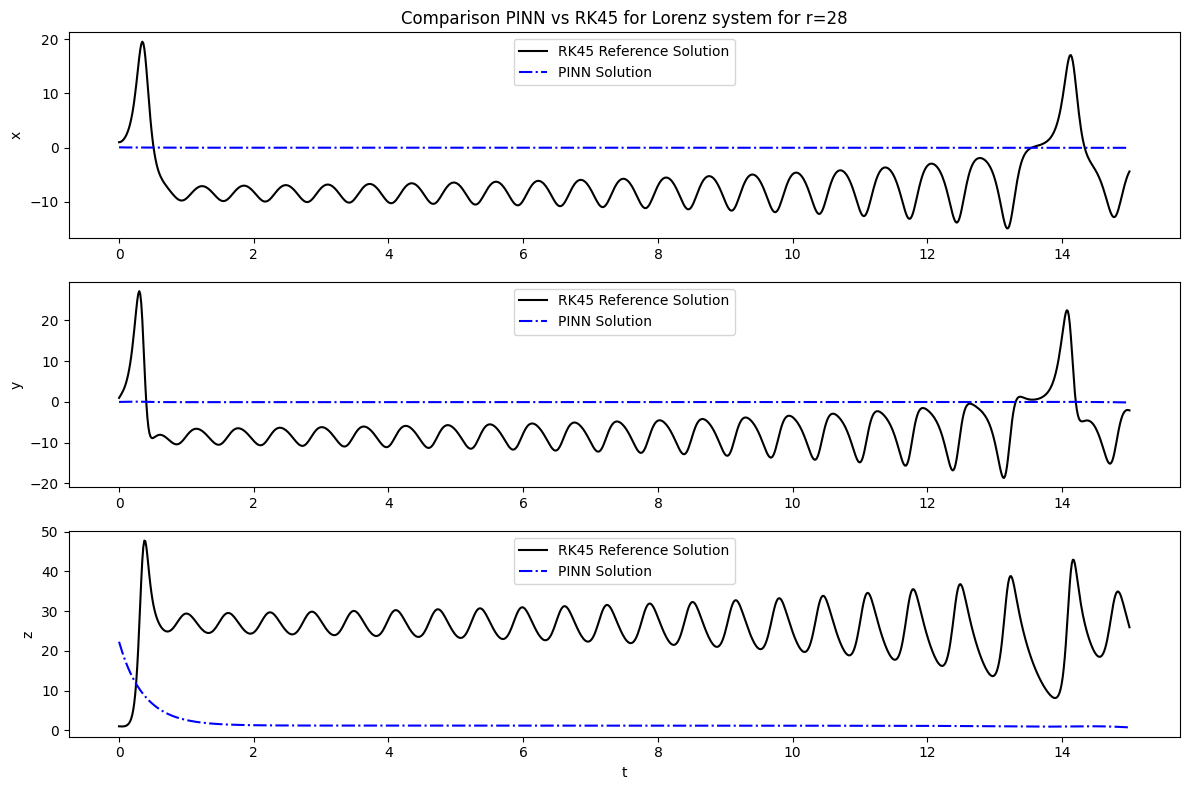

In [81]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

Training result still has no accuracy

## Test 18: t_max = 5

In [101]:
# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.08
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 15000 
COLLOCATION_POINTS = 4000
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 5.0

In [102]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=False
    )

Training started...
Epoch     0 | Loss: 6.3342e+01 | Data/IC-Loss: 1.2348e+02 | Physics-Loss: 3.2080e+00
Epoch  1000 | Loss: 1.2630e+01 | Data/IC-Loss: 2.5007e+01 | Physics-Loss: 2.5281e-01
Epoch  2000 | Loss: 1.2502e+01 | Data/IC-Loss: 2.4830e+01 | Physics-Loss: 1.7436e-01
Epoch  3000 | Loss: 1.2483e+01 | Data/IC-Loss: 2.4807e+01 | Physics-Loss: 1.5967e-01
Epoch  4000 | Loss: 1.2485e+01 | Data/IC-Loss: 2.4805e+01 | Physics-Loss: 1.6456e-01
Epoch  5000 | Loss: 1.2483e+01 | Data/IC-Loss: 2.4805e+01 | Physics-Loss: 1.6082e-01
Epoch  6000 | Loss: 1.2485e+01 | Data/IC-Loss: 2.4805e+01 | Physics-Loss: 1.6572e-01
Epoch  7000 | Loss: 1.2486e+01 | Data/IC-Loss: 2.4805e+01 | Physics-Loss: 1.6722e-01
Epoch  8000 | Loss: 1.2485e+01 | Data/IC-Loss: 2.4805e+01 | Physics-Loss: 1.6610e-01
Epoch  9000 | Loss: 1.2485e+01 | Data/IC-Loss: 2.4805e+01 | Physics-Loss: 1.6564e-01
Epoch 10000 | Loss: 1.2484e+01 | Data/IC-Loss: 2.4805e+01 | Physics-Loss: 1.6428e-01
Epoch 11000 | Loss: 1.2483e+01 | Data/IC-Loss

In [103]:
y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)

## Results of Test 18 (t_max = 5)

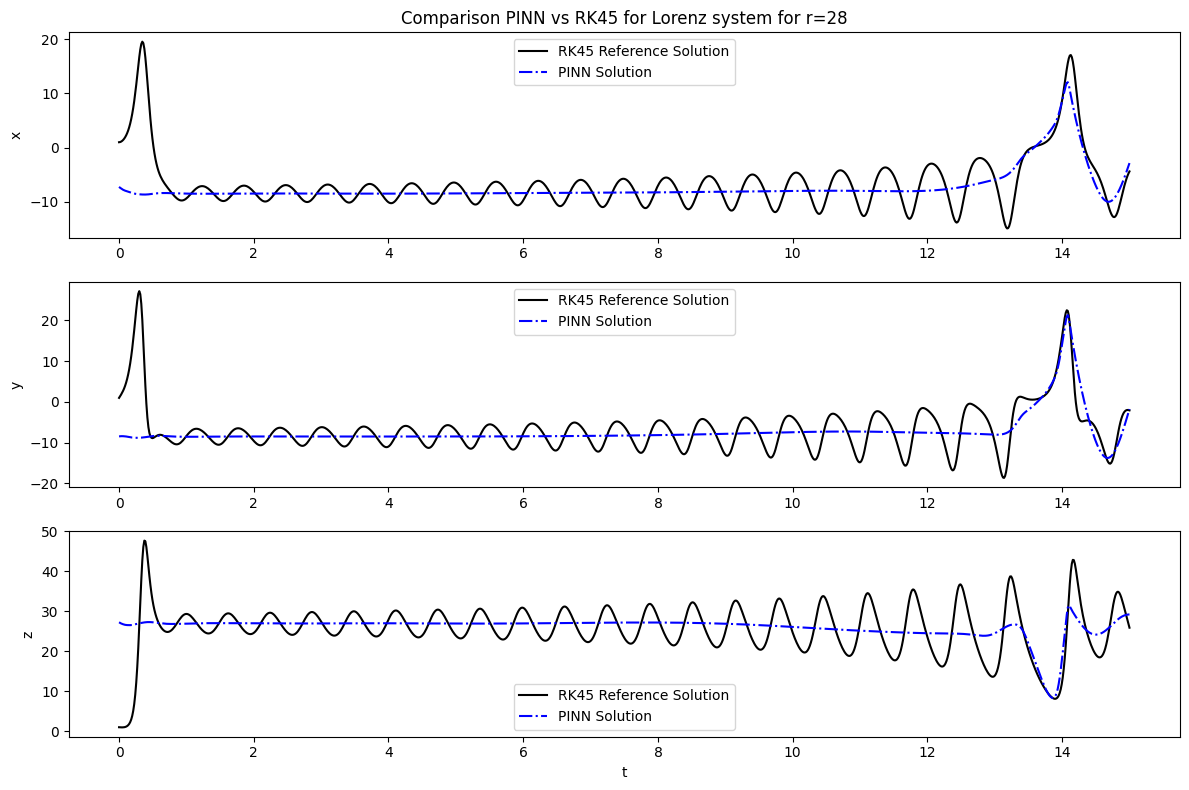

In [104]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

Training has changed dramaticly. Accuracy increased a lot

## Test 19: normalize input = true

In [ ]:
# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.08
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 15000 
COLLOCATION_POINTS = 4000
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

In [88]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=True,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=False
    )

Training started...
Epoch     0 | Loss: 1.6531e+01 | Data/IC-Loss: 3.3022e+01 | Physics-Loss: 3.9893e-02
Epoch  1000 | Loss: 1.6103e+01 | Data/IC-Loss: 3.2153e+01 | Physics-Loss: 5.2707e-02
Epoch  2000 | Loss: 1.6020e+01 | Data/IC-Loss: 3.1989e+01 | Physics-Loss: 5.0906e-02
Epoch  3000 | Loss: 1.6010e+01 | Data/IC-Loss: 3.1972e+01 | Physics-Loss: 4.9035e-02
Epoch  4000 | Loss: 1.6009e+01 | Data/IC-Loss: 3.1970e+01 | Physics-Loss: 4.7959e-02
Epoch  5000 | Loss: 1.6010e+01 | Data/IC-Loss: 3.1970e+01 | Physics-Loss: 5.0049e-02
Epoch  6000 | Loss: 1.6009e+01 | Data/IC-Loss: 3.1970e+01 | Physics-Loss: 4.7842e-02
Epoch  7000 | Loss: 1.6009e+01 | Data/IC-Loss: 3.1970e+01 | Physics-Loss: 4.8685e-02
Epoch  8000 | Loss: 1.6009e+01 | Data/IC-Loss: 3.1970e+01 | Physics-Loss: 4.9022e-02
Epoch  9000 | Loss: 1.6010e+01 | Data/IC-Loss: 3.1970e+01 | Physics-Loss: 4.9603e-02
Epoch 10000 | Loss: 1.6010e+01 | Data/IC-Loss: 3.1970e+01 | Physics-Loss: 4.9488e-02
Epoch 11000 | Loss: 1.6010e+01 | Data/IC-Loss

In [89]:
y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)

## Results of Test 19 (normalized input)

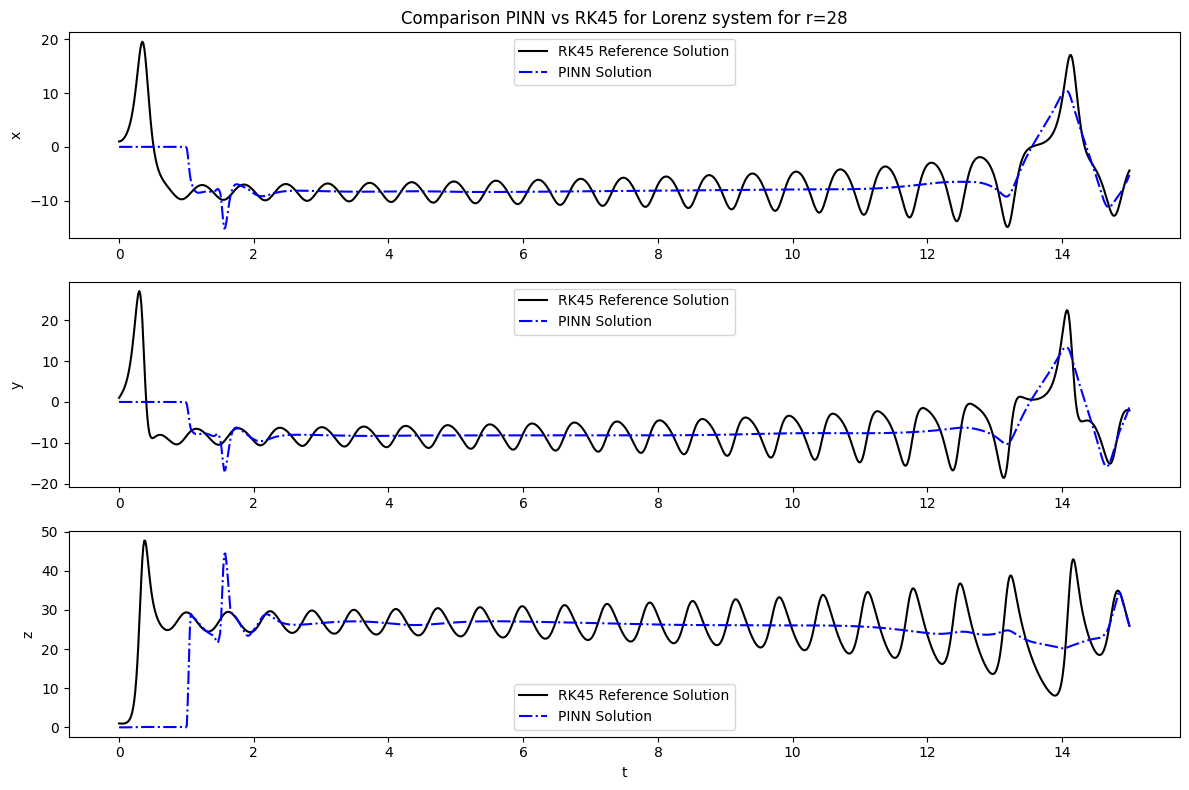

In [90]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

Normalization has resulted in a dramatic difference in the graphing

## Test 20: chaotic = true

In [9]:
# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.8
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 25000 
COLLOCATION_POINTS = 4000
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

In [10]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=True
    )

Training started...
Epoch     0 | Loss: 1.3955e+02 | Data/IC-Loss: 2.7810e+02 | Physics-Loss: 1.0000e+00
Epoch  1000 | Loss: 9.1327e+00 | Data/IC-Loss: 1.7265e+01 | Physics-Loss: 1.0000e+00
Epoch  2000 | Loss: 6.0335e+00 | Data/IC-Loss: 1.1067e+01 | Physics-Loss: 1.0000e+00
Epoch  3000 | Loss: 5.7162e+00 | Data/IC-Loss: 1.0432e+01 | Physics-Loss: 1.0000e+00
Epoch  4000 | Loss: 4.2899e+00 | Data/IC-Loss: 7.5797e+00 | Physics-Loss: 1.0000e+00
Epoch  5000 | Loss: 3.5657e+00 | Data/IC-Loss: 6.1313e+00 | Physics-Loss: 1.0000e+00
Epoch  6000 | Loss: 3.2672e+00 | Data/IC-Loss: 5.5343e+00 | Physics-Loss: 1.0000e+00
Epoch  7000 | Loss: 3.1199e+00 | Data/IC-Loss: 5.2398e+00 | Physics-Loss: 1.0000e+00
Epoch  8000 | Loss: 2.8967e+00 | Data/IC-Loss: 4.7935e+00 | Physics-Loss: 1.0000e+00
Epoch  9000 | Loss: 2.6867e+00 | Data/IC-Loss: 4.3734e+00 | Physics-Loss: 1.0000e+00
Epoch 10000 | Loss: 2.5466e+00 | Data/IC-Loss: 4.0932e+00 | Physics-Loss: 1.0000e+00
Epoch 11000 | Loss: 1.9073e+00 | Data/IC-Loss

In [11]:
y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)

## Results of Test 20

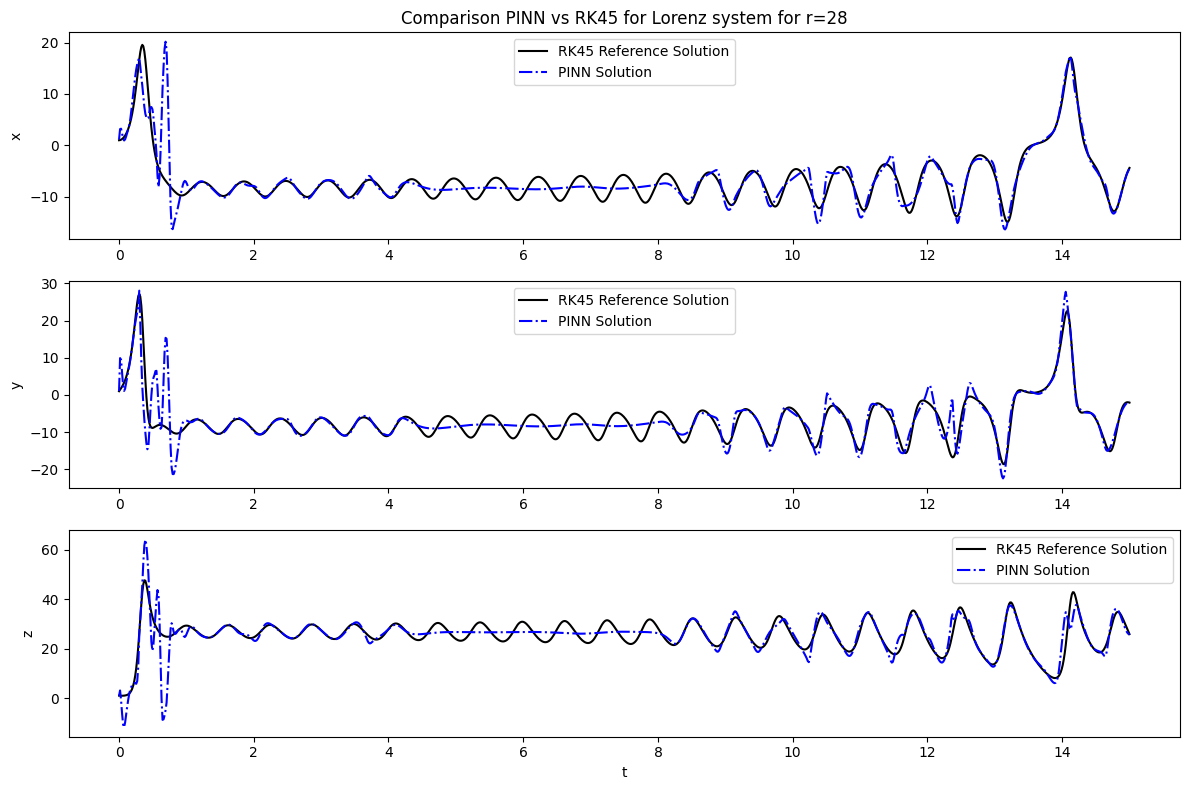

In [12]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

Best training output of all tests. Chaotic funktion is enableing better training

## Inverse problem based on the investigated parameters


==== Starte Training für r = 28, IC = [1. 1. 1.] ====
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>
Training started...
Epoch 0: Total=277.3473815917969, Physics=0.014201083220541477, Data=280.1487121582031, A=10.0000, B=0.9947, C=2.6667
Epoch 1000: Total=64.33172607421875, Physics=2513.866455078125, Data=39.58894729614258, A=10.0000, B=10.6464, C=2.6667
Epoch 2000: Total=31.877674102783203, Physics=536.4349975585938, Data=26.78113555908203, A=10.0000, B=19.4110, C=2.6667
Epoch 3000: Total=23.755645751953125, Physics=162.4224395751953, Data=22.354970932006836, A=10.0000, B=23.4329, C=2.6667
Epoch 4000: Total=13.861227989196777, Physics=197.45709228515625, Data=12.006723403930664, A=10.0000, B=25.5249, C=2.6667
Epoch 5000: Total=5.216643810272217, Physics=27.674917221069336, Data=4.989792346954346, A=10.0000, B=26.8540, C=2.6667
Epoch 6000: Total=3.4768736362457275, Physics=10.598542213439941, Data=3.404937505722046, A=10.0000, B=27.4497, C=2.6667
Epoch 7000: Total=2.837

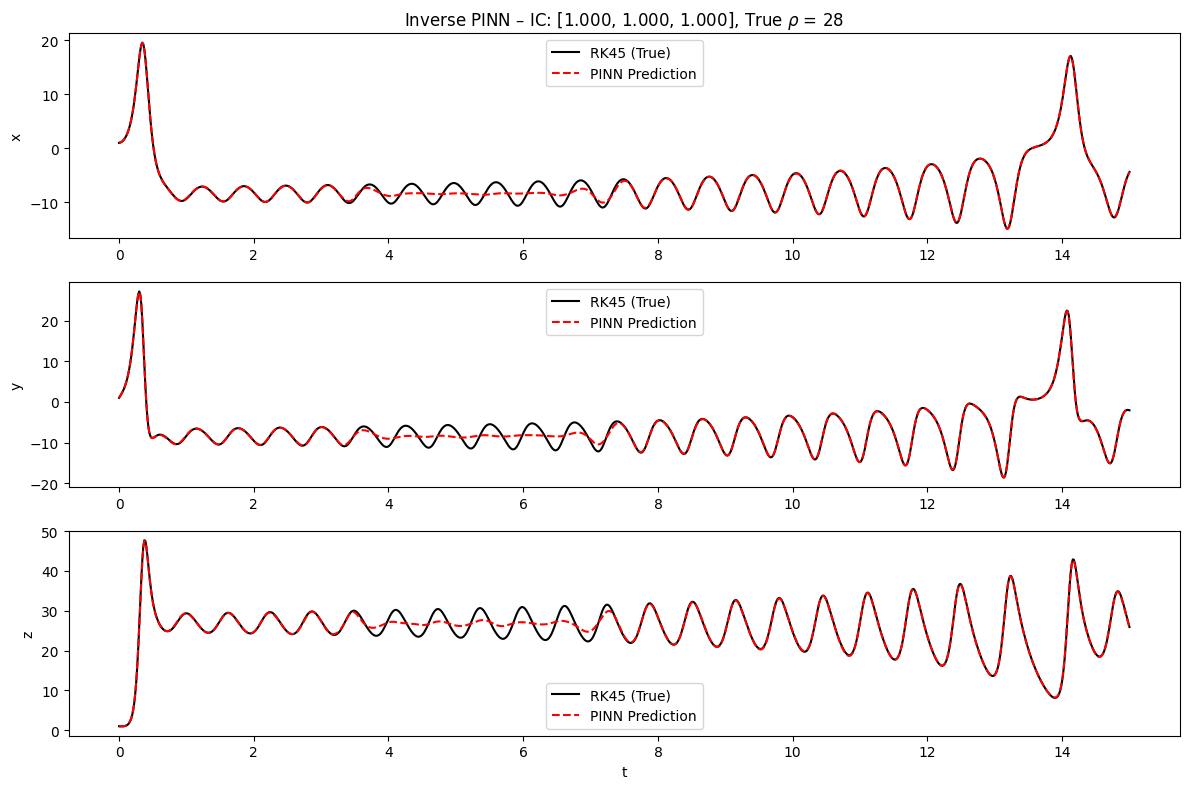


==== Starte Training für r = 28, IC = [10. -5. 20.] ====
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>
Training started...
Epoch 0: Total=254.03521728515625, Physics=0.002379260491579771, Data=256.6011962890625, A=10.0000, B=1.0006, C=2.6667
Epoch 1000: Total=55.00732421875, Physics=1666.158203125, Data=38.73307418823242, A=10.0000, B=11.7357, C=2.6667
Epoch 2000: Total=24.42719268798828, Physics=515.6478271484375, Data=19.465368270874023, A=10.0000, B=19.6652, C=2.6667
Epoch 3000: Total=4.245856761932373, Physics=124.32254791259766, Data=3.0329606533050537, A=10.0000, B=23.7516, C=2.6667
Epoch 4000: Total=1.4282962083816528, Physics=23.913536071777344, Data=1.2011725902557373, A=10.0000, B=26.0278, C=2.6667
Epoch 5000: Total=0.34689998626708984, Physics=20.468114852905273, Data=0.14365538954734802, A=10.0000, B=27.2140, C=2.6667
Epoch 6000: Total=0.20157591998577118, Physics=4.549439430236816, Data=0.15765810012817383, A=10.0000, B=27.7449, C=2.6667
Epoch 7000: Total=0

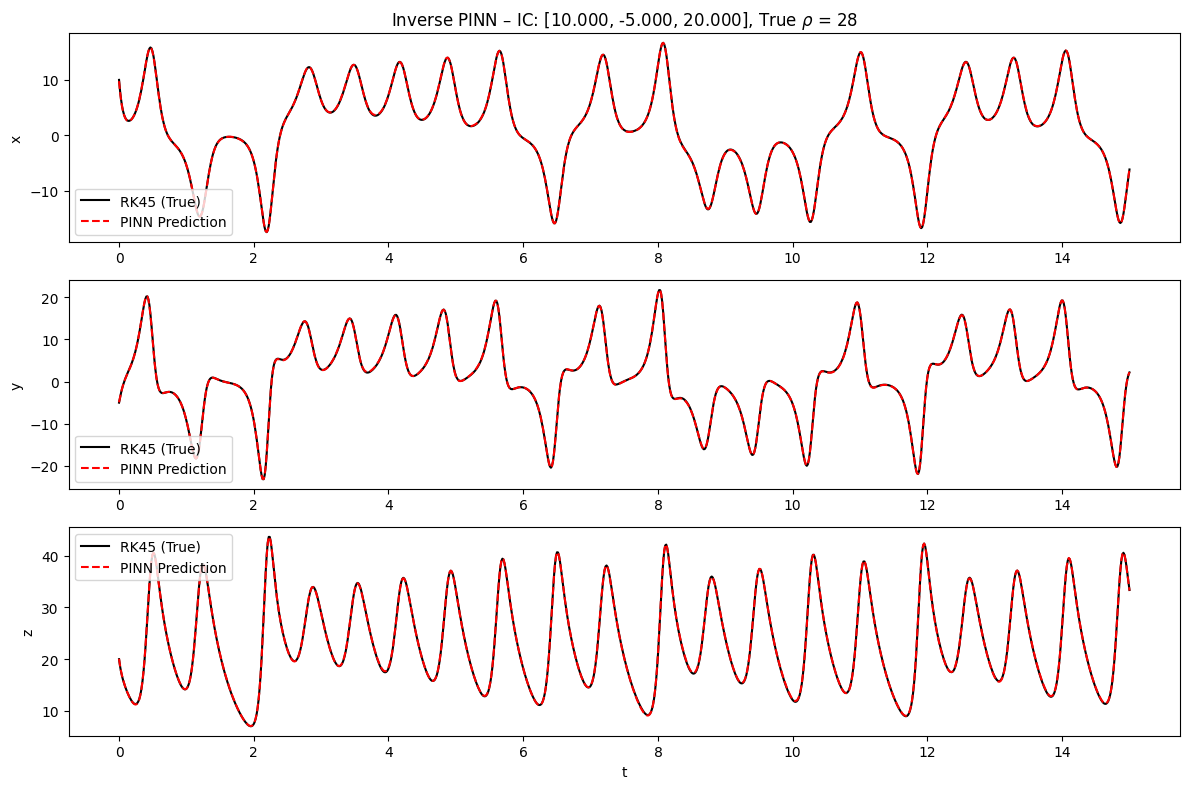


==== Starte Training für r = 28, IC = [0. 1. 0.] ====
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>
Training started...
Epoch 0: Total=284.2733459472656, Physics=0.0070047141052782536, Data=287.14471435546875, A=10.0000, B=0.9989, C=2.6667
Epoch 1000: Total=50.95329284667969, Physics=1918.41748046875, Data=32.09001922607422, A=10.0000, B=12.1697, C=2.6667
Epoch 2000: Total=18.533296585083008, Physics=414.43280029296875, Data=14.534311294555664, A=10.0000, B=20.1068, C=2.6667
Epoch 3000: Total=9.53592300415039, Physics=143.0987548828125, Data=8.186803817749023, A=10.0000, B=24.0608, C=2.6667
Epoch 4000: Total=7.179741859436035, Physics=20.16291046142578, Data=7.048598766326904, A=10.0000, B=26.1352, C=2.6667
Epoch 5000: Total=6.799131393432617, Physics=4.3757243156433105, Data=6.823609828948975, A=10.0000, B=27.0405, C=2.6667
Epoch 6000: Total=6.751288890838623, Physics=2.2868378162384033, Data=6.796384334564209, A=10.0000, B=27.4095, C=2.6667
Epoch 7000: Total=6.7380928

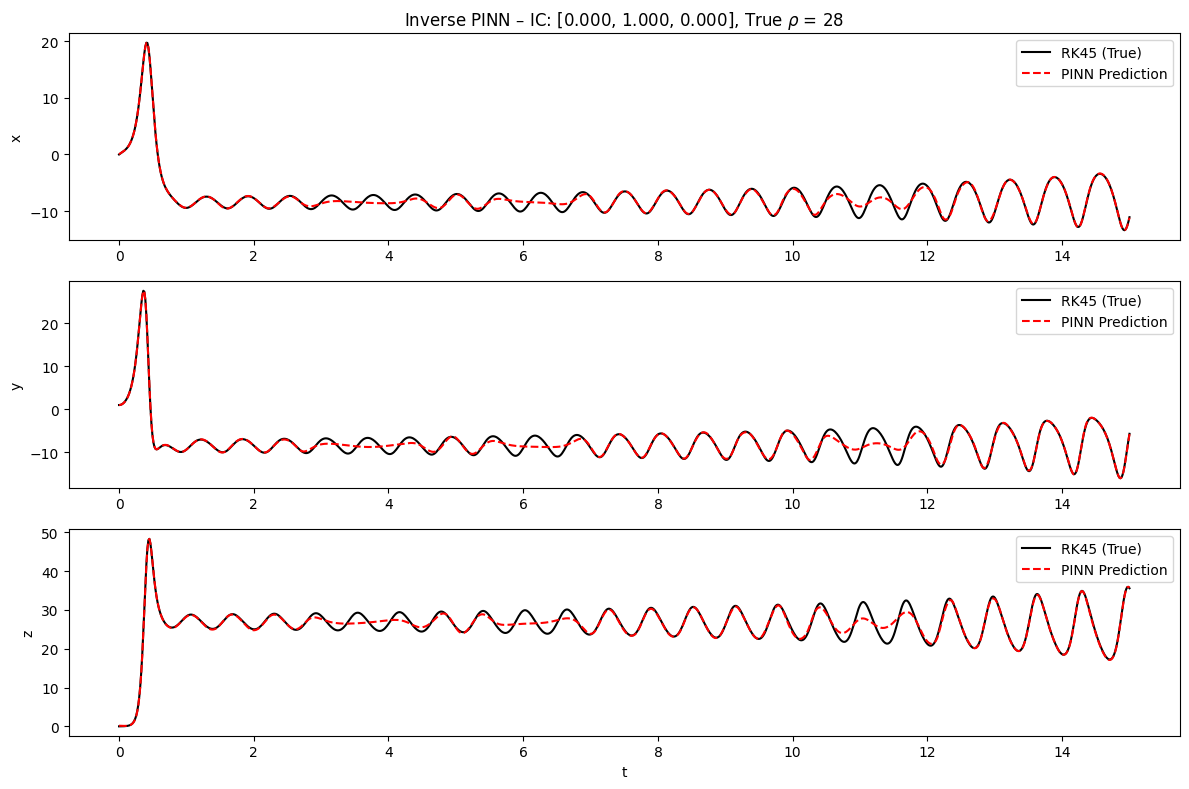


==== Starte Training für r = 28, IC = [0.     0.0001 0.    ] ====
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>
Training started...
Epoch 0: Total=269.63665771484375, Physics=0.000641313090454787, Data=272.3602600097656, A=10.0000, B=0.9996, C=2.6667
Epoch 1000: Total=59.211944580078125, Physics=2741.0068359375, Data=32.123104095458984, A=10.0000, B=9.3048, C=2.6667
Epoch 2000: Total=21.613367080688477, Physics=644.208740234375, Data=15.324524879455566, A=10.0000, B=18.5469, C=2.6667
Epoch 3000: Total=9.585342407226562, Physics=146.20274353027344, Data=8.205368041992188, A=10.0000, B=23.0325, C=2.6667
Epoch 4000: Total=6.2453460693359375, Physics=29.82182502746582, Data=6.007199764251709, A=10.0000, B=25.4944, C=2.6667
Epoch 5000: Total=5.458234786987305, Physics=10.317706108093262, Data=5.409149169921875, A=10.0000, B=26.7748, C=2.6667
Epoch 6000: Total=5.265918731689453, Physics=3.4512453079223633, Data=5.2842488288879395, A=10.0000, B=27.3359, C=2.6667
Epoch 7000: To

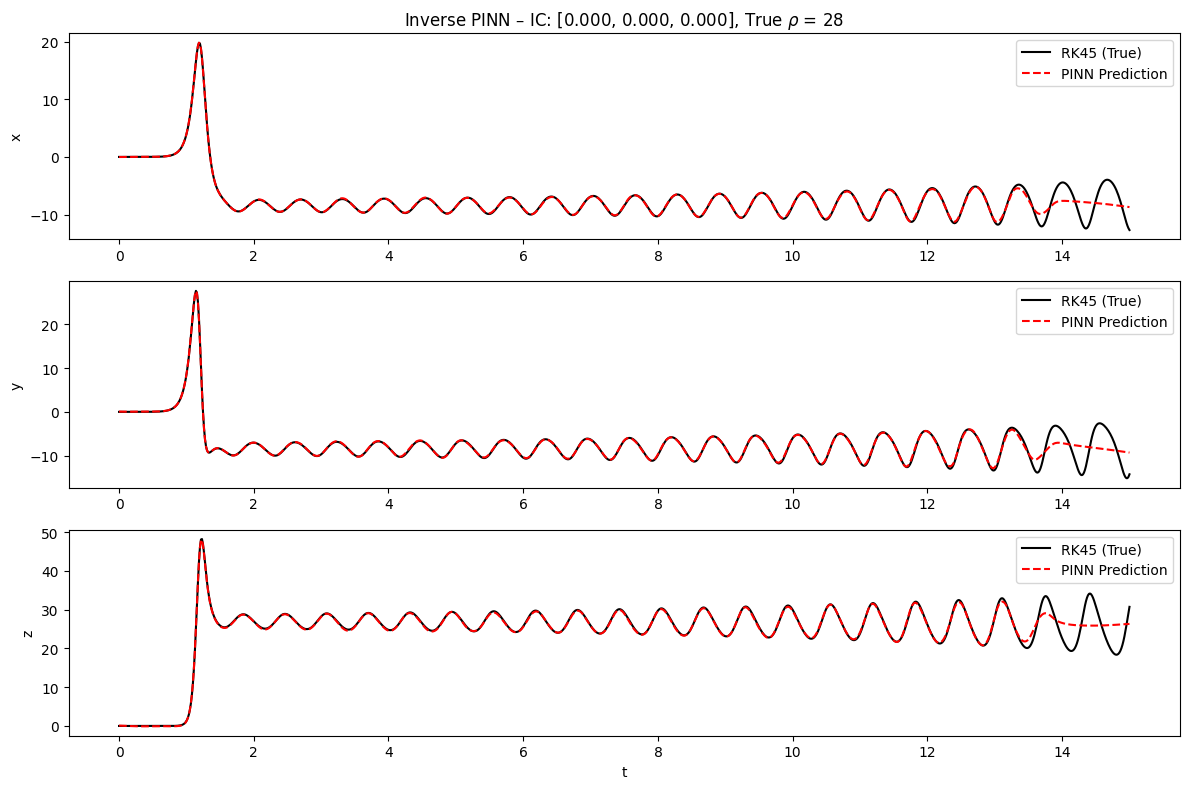


==== Starte Training für r = 28, IC = [0.5 0.5 0.1] ====
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>
Training started...
Epoch 0: Total=283.3304443359375, Physics=0.020878035575151443, Data=286.192138671875, A=10.0000, B=0.9957, C=2.6667
Epoch 1000: Total=47.875892639160156, Physics=1698.6387939453125, Data=31.201522827148438, A=10.0000, B=12.9025, C=2.6667
Epoch 2000: Total=17.834339141845703, Physics=373.8290710449219, Data=14.238433837890625, A=10.0000, B=20.4515, C=2.6667
Epoch 3000: Total=9.627528190612793, Physics=76.69284057617188, Data=8.950100898742676, A=10.0000, B=24.2499, C=2.6667
Epoch 4000: Total=7.743199825286865, Physics=15.379521369934082, Data=7.666065216064453, A=10.0000, B=26.1683, C=2.6667
Epoch 5000: Total=7.397947311401367, Physics=4.192831039428711, Data=7.430322170257568, A=10.0000, B=27.0522, C=2.6667
Epoch 6000: Total=7.356561660766602, Physics=4.3892951011657715, Data=7.386534214019775, A=10.0000, B=27.3685, C=2.6667
Epoch 7000: Total=7.312

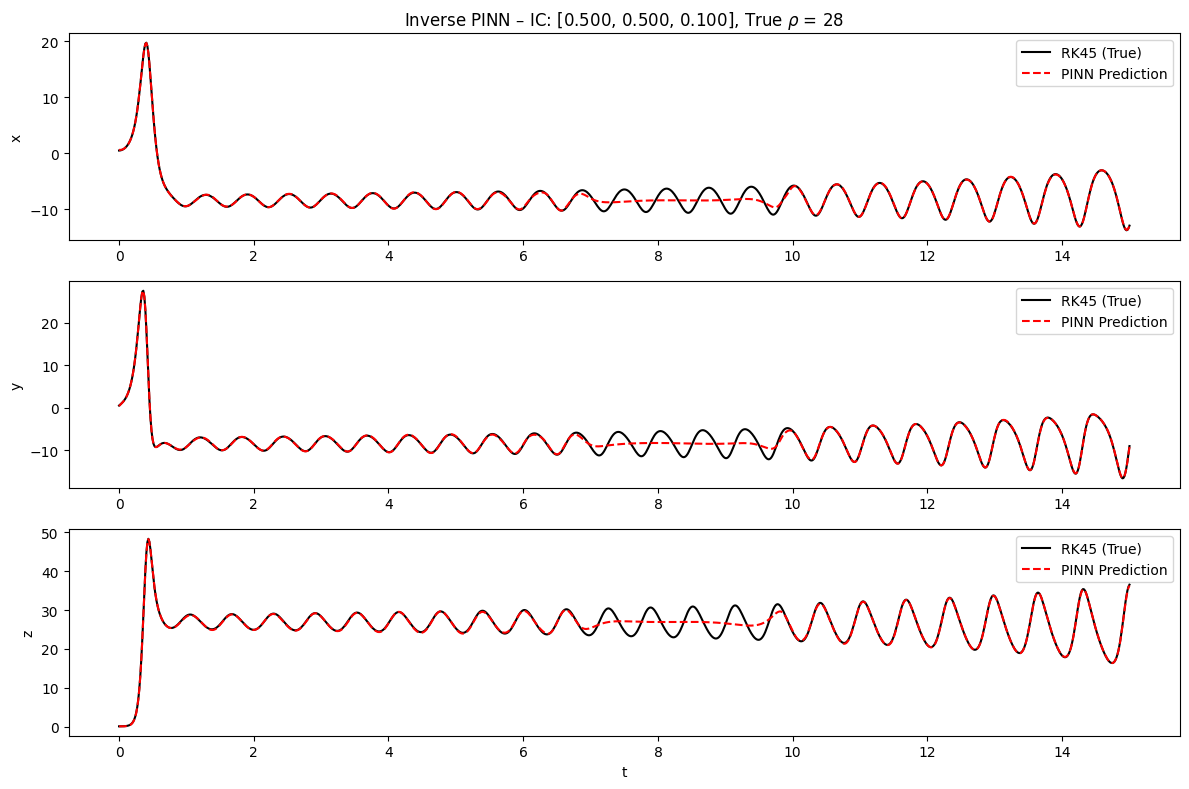

   true_r  estimated_r                 initial_conditions
0      28    27.904984                    [1.0, 1.0, 1.0]
1      28    28.005693                 [10.0, -5.0, 20.0]
2      28    27.883812                    [0.0, 1.0, 0.0]
3      28    27.818583  [0.0, 9.999999747378752e-05, 0.0]
4      28    27.899714    [0.5, 0.5, 0.10000000149011612]


In [ ]:

# PINN architecture
HIDDEN_LAYER = 10
NEURONS_PER_LAYER = 50
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

LEARNING_RATE = 0.01
DECAY_RATE = 0.8
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 20000
COLLOCATION_POINTS = 4000
ALPHA_DATA = 0.99
NORMALIZE_INPUT = False
DATA_ACTIVE = True

# Time domain
t_min, t_max = 0.0, 15.0

# Parameters and initial conditions
r_values = [28]
initial_conditions_list = [
    np.array([1.0, 1.0, 1.0], dtype=np.float32),
    np.array([10.0, -5.0, 20.0], dtype=np.float32),
    np.array([0.0, 1.0, 0.0], dtype=np.float32),
    np.array([0.0, 0.0001, 0.0], dtype=np.float32),
    np.array([0.5, 0.5, 0.1], dtype=np.float32)
]

# Save result
results = []

# Simulations throughout every combination
for r in r_values:
    for ic in initial_conditions_list:
        print(f"\n==== Starte Training für r = {r}, IC = {ic} ====")

        # Ground truth parameter
        True_A, True_B, True_C = 10.0, r, 8/3

        # Reference data
        t_eval, sol = hf.ref_solution(True_A, True_B, True_C, t_min, t_max, ic)
        t_data, y_data = hf.generate_noisy_data(sol, t_min, t_max, noise_factor=0.2)

        # Initialise model
        model = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)

        # Set trainable parameters
        A = tf.Variable(10.0, dtype=tf.float32, trainable=False)
        B = tf.Variable(1.0, dtype=tf.float32, trainable=True)  # r soll gelernt werden
        C = tf.Variable(8/3, dtype=tf.float32, trainable=False)

        # Training
        train(
            model,
            t_initial=t_min,
            initial_conditions=ic,
            A=A, B=B, C=C,
            t_min=t_min, t_max=t_max,
            collocation_points=COLLOCATION_POINTS,
            alpha=ALPHA_DATA,
            learning_rate=LEARNING_RATE,
            decay_rate=DECAY_RATE,
            epochs=EPOCHS,
            optimizer_class=OPTIMIZER,
            normalize_input=NORMALIZE_INPUT,
            t_data=t_data,
            y_data=y_data,
            trainable_parameters=[B],
            chaotic=False
        )

        # Evaluation
        print(f"✅ Ergebnis für r = {r}, IC = {ic}")
        evaluate_and_plot(model, t_eval, sol, (A, B, C), (True_A, True_B, True_C), initial_conditions=ic)

        results.append({
            "true_r": r,
            "estimated_r": B.numpy(),
            "initial_conditions": ic.tolist()
        })

# Show results
df = pd.DataFrame(results)
print(df)


## Ergebnisse für die Parameterbestimmung des inversen Problems für chaotisches Verhalten

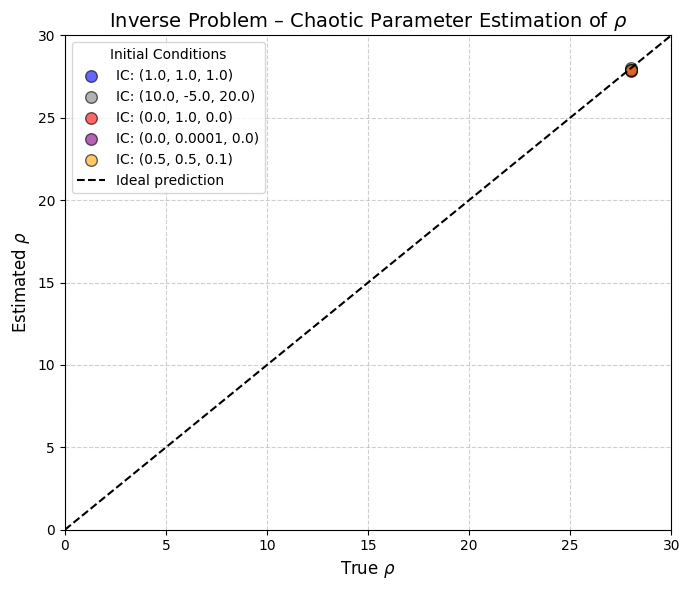

In [ ]:
"""Plot all predicted results against ground truth results"""

plt.figure(figsize=(7, 6))
seen_labels = set()

for _, row in df.iterrows():
    ic_tuple = tuple(np.round(row["initial_conditions"], 4).astype(float))

    color = color_map.get(ic_tuple, 'gray')
    label = label_map.get(ic_tuple, f"IC: ({ic_tuple[0]:.1f}, {ic_tuple[1]:.1f}, {ic_tuple[2]:.1f})"
)


    if label not in seen_labels:
        plt.scatter(row["true_r"], row["estimated_r"], color=color, label=label,
                    s=70, alpha=0.6, edgecolor='k')
        seen_labels.add(label)
    else:
        plt.scatter(row["true_r"], row["estimated_r"], color=color,
                    s=70, alpha=0.6, edgecolor='k')

# diagonal
plt.plot([0 ,30], [0 ,30], 'k--', label='Ideal prediction')

plt.xlim(0 , 30)
plt.ylim(0 ,30)

plt.xlabel("True $\\rho$", fontsize=12)
plt.ylabel("Estimated $\\rho$", fontsize=12)
plt.title("Inverse Problem – Chaotic Parameter Estimation of $\\rho$", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Initial Conditions", loc='best')
plt.tight_layout()
plt.show()
